In [1]:
import pandas as pd
import numpy as np
import sqlite3
import re

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline  
plt.rcParams.update({'figure.figsize': (8,6)})

import seaborn as sns
from sklearn.cluster import DBSCAN


import hdbscan
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
plt.style.use('default')

In [2]:
conn = sqlite3.connect('IowaLiquor.db')
sales = pd.read_sql_query(
    "SELECT I.ItemNumber, P.ItemDescription, Date, Sale, BottlesSold, Proof, Age, I.StoreNumber, StoreName, "
        "P.CategoryName, I.BottleVolume, I.VendorNumber, VendorName, Latitude, Longitude, County "
    "FROM Invoice as I "
    "INNER JOIN Item as P on I.ItemNumber=P.ItemNumber "
    "and I.BottleVolume=P.BottleVolume "
    "and I.VendorNumber=P.VendorNumber "
    "INNER JOIN store as S on I.StoreNumber=S.StoreNumber "
    "WHERE S.StoreName Like '%Hy-Vee%'", conn)
sales.to_csv('hy-vee.csv')

# Import Hy-Vee Sales Data

In [2]:
sales = pd.read_csv('hy-vee.csv')
sales.drop(columns='Unnamed: 0', inplace=True)
sales['Date'] = pd.to_datetime(sales['Date'], format='%m/%d/%Y', errors='ignore')
sales.index = sales.Date

Check store names to assign store type:
- General Store
- Food Store
- Food & Drugstore
- Wine & Spirits
- Drugstore

In [3]:
storenames = [re.sub(' \d|\d','', i) for i in sales['StoreName'].unique()]
set(storenames)

# Create store type
sales['StoreType'] = 'General Store'
sales.loc[sales.StoreName.str.contains('Food Store'), 'StoreType'] = 'Food Store'
sales.loc[sales.StoreName.str.contains('Wine & Spirits'), 'StoreType'] = 'Wine & Spirits'
sales.loc[sales.StoreName.str.contains('Food & Drug'), 'StoreType'] = 'Food & Drugstore'
sales.loc[sales.StoreName=='Drugstore', 'StoreType'] = 'Drugstore'

# High-Level Analysis
- Gain insights into stores
    - Sales
    - Number of Stores over time
    - Average store life
    - Average sales/store
    - Separate by store type
- Gain insights into products
    - Number of new products
    - Different product categories
    - Which ones are the most popular?
    - Separate by product categories

### Total number of stores over time

- Very strange that the number of stores seems to skyrocket in 2019

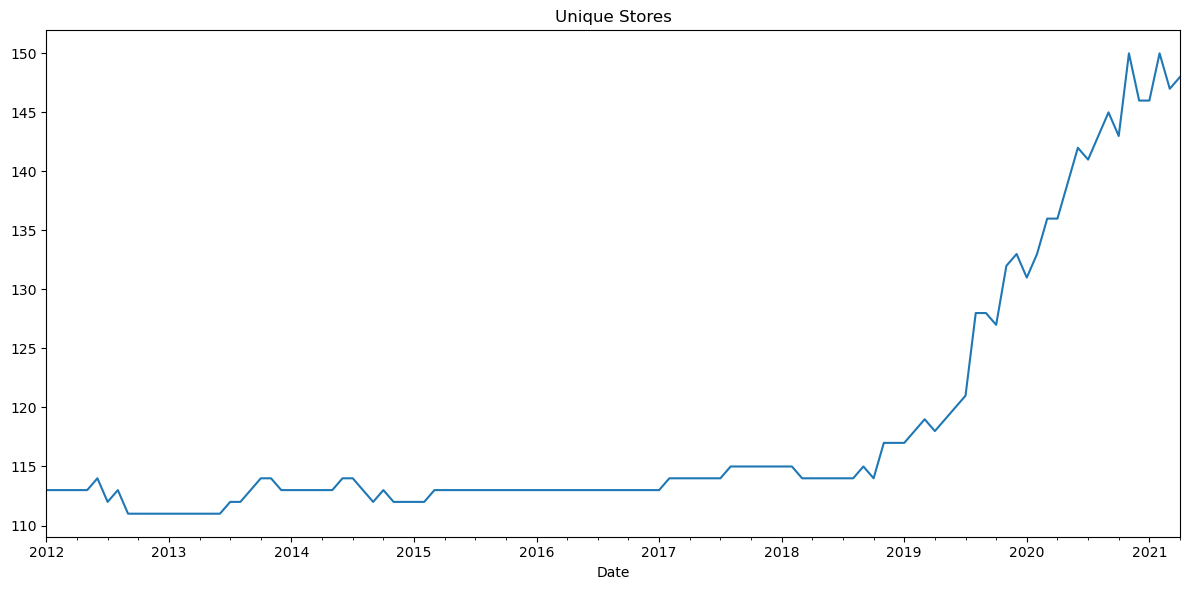

In [4]:
totalStores = sales.groupby(['StoreNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalStores = totalStores.reset_index('Date').pivot_table(index='StoreNumber', columns='Date', aggfunc=np.sum)
totalStores.columns = totalStores.columns.droplevel(0)

f,ax = plt.subplots(figsize = (12,6))
totalStores.count().plot()
ax.set_title('Unique Stores')
f.tight_layout()

### Now separately by store type
- Increase came from the establishment of new general stores

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:6822: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  return pivot_table(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


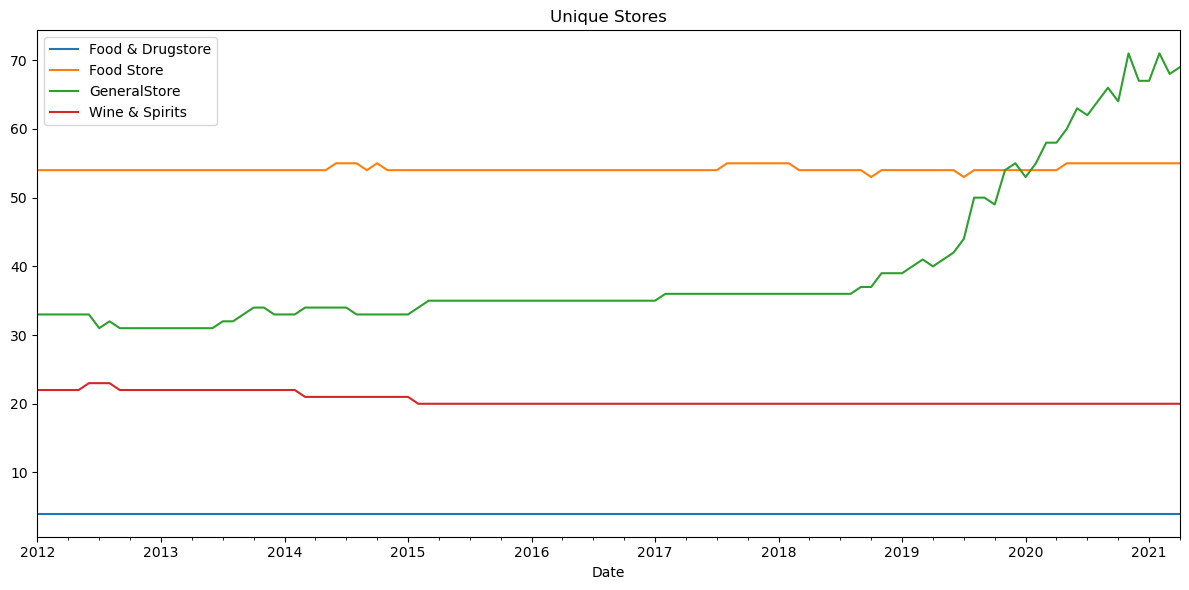

In [5]:
totalStores = sales.groupby(['StoreType', 'StoreNumber', pd.Grouper(key='Date', freq='M')]).agg({'Sale':['sum']})
totalStores = totalStores.reset_index('Date').pivot_table(index='Date', columns='StoreType', aggfunc='count')
totalStores.columns = ['Food & Drugstore', 'Food Store', 'GeneralStore', 'Wine & Spirits']

f,ax = plt.subplots(figsize = (12,6))
totalStores.plot(ax=ax)
ax.set_title('Unique Stores', fontsize=12)
f.tight_layout()

### Mean Store Life
- Examine average survival rate of stores overall and by store stype

<AxesSubplot:ylabel='Frequency'>

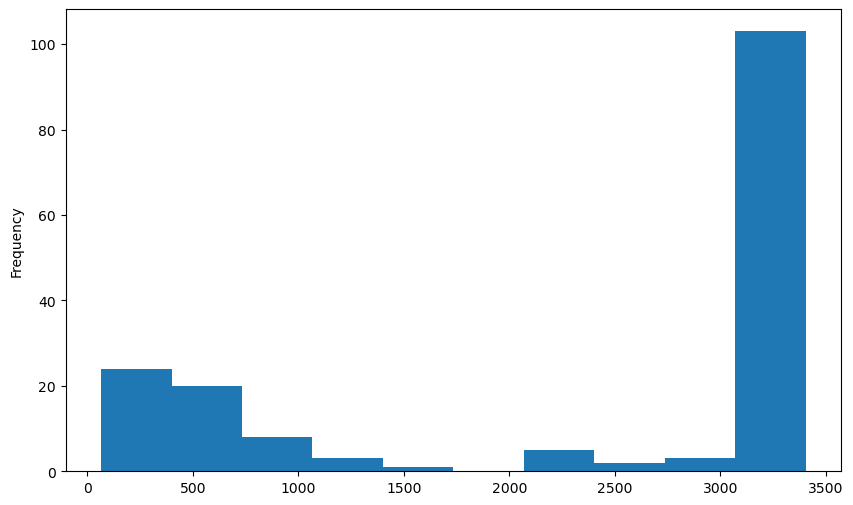

In [6]:
storeLife = sales.groupby(['StoreNumber']).agg(
    FirstDate = ('Date',min),
    LastDate = ('Date',max)
)
storeLife['SurvivalDuration'] = storeLife['LastDate'] - storeLife['FirstDate']
storeLife['SurvivalDuration'].dt.days.plot(kind='hist', figsize=(10,6))

<AxesSubplot:ylabel='Frequency'>

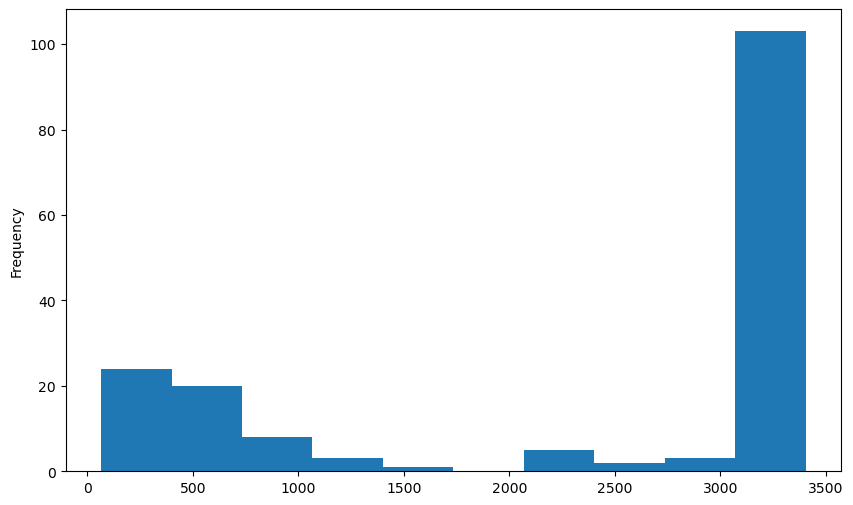

In [7]:
storeLife = sales.groupby(['StoreType','StoreNumber']).agg(
    FirstDate = ('Date',min),
    LastDate = ('Date',max)
)
storeLife['SurvivalDuration'] = storeLife['LastDate'] - storeLife['FirstDate']
storeLife['SurvivalDuration'].dt.days.plot(kind='hist', figsize=(10,6))

Confirms that general stores are usually younger.

<AxesSubplot:ylabel='StoreType'>

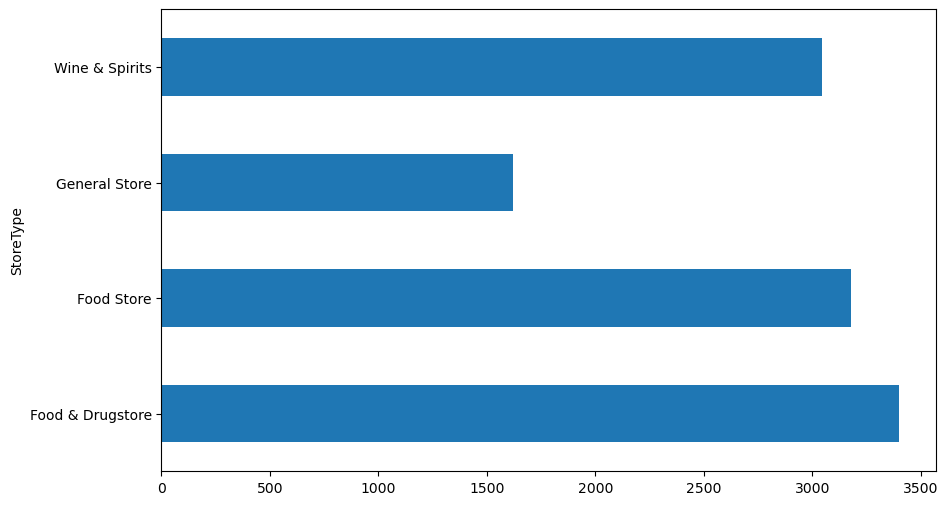

In [8]:
storeLife = sales.groupby(['StoreType','StoreNumber']).agg(
    FirstDate = ('Date',min),
    LastDate = ('Date',max)
)
storeLife['SurvivalDuration'] = storeLife['LastDate'] - storeLife['FirstDate']
storeLife['SurvivalDuration'] = storeLife['SurvivalDuration'].dt.days
storeLife = storeLife.groupby('StoreType').agg(SurvivalDuration = ('SurvivalDuration','mean'))
storeLife['SurvivalDuration'].plot(kind='barh', figsize=(10,6))

### Sales per store

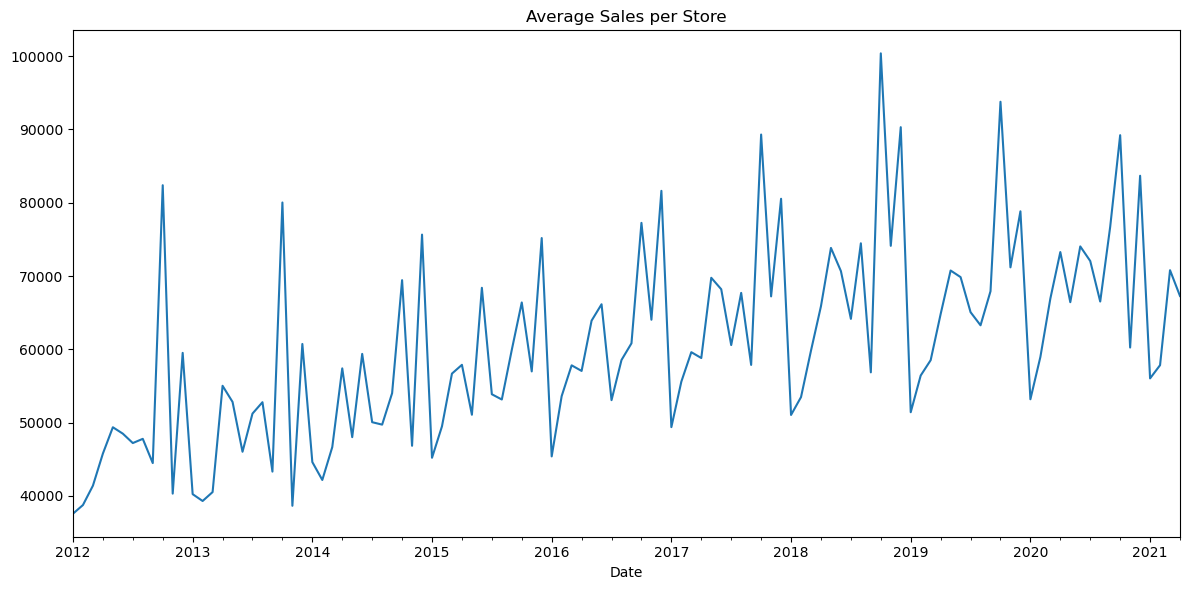

In [9]:
totalStores = sales.groupby(['StoreNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalSales = totalStores.reset_index().groupby('Date').agg(Sale=('Sale','sum'))

totalStores = totalStores.reset_index().groupby('Date').agg(Stores=('StoreNumber', 'count'))
avg_sales_per_store = totalSales.Sale/totalStores.Stores
f,ax = plt.subplots(figsize = (12,6))
pd.DataFrame(avg_sales_per_store,index=totalStores.index).plot(ax=ax, legend=None)
ax.set_title('Average Sales per Store')
f.tight_layout()

Seems likes the number of general stores is increasing faster than sales growth. This can be seen in the decrease in averaqge sales per store.

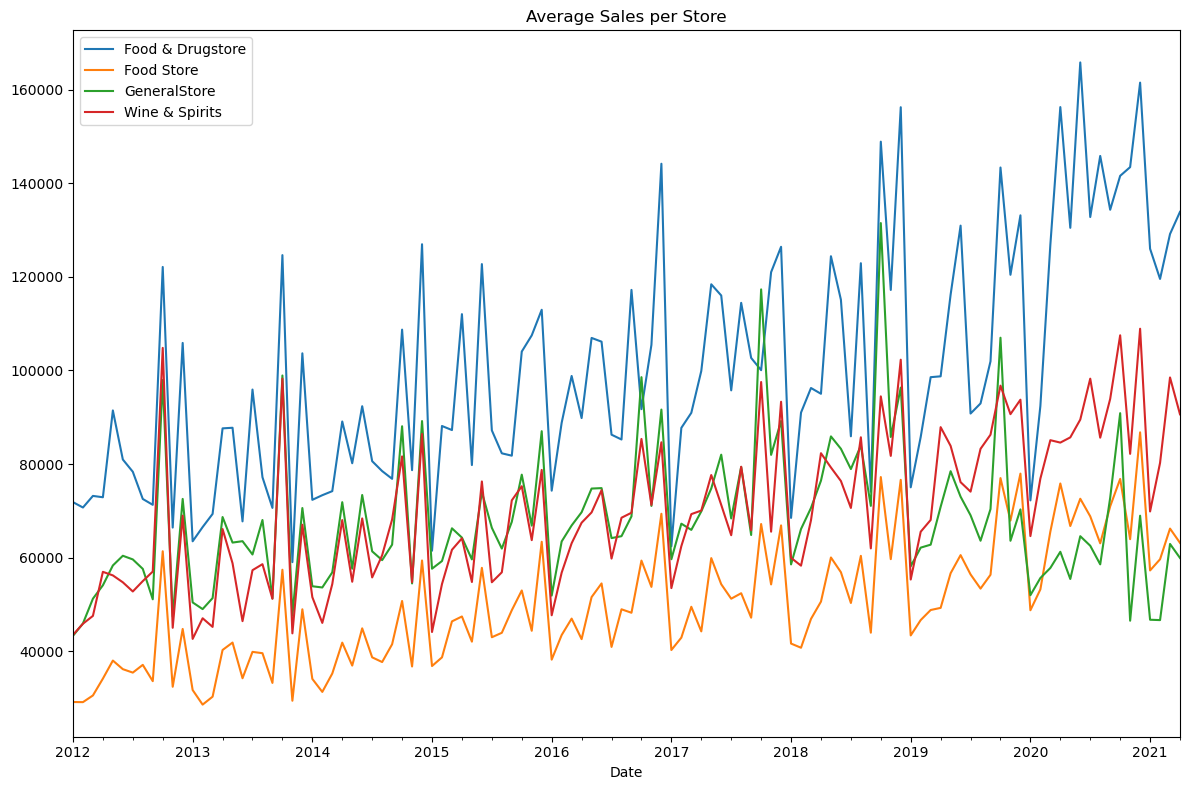

In [10]:
df = sales.groupby(['StoreType','StoreNumber',pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
df = df.reset_index().groupby(['StoreType', 'Date']).agg(
    Sale=('Sale','sum'),
    Count=('StoreNumber','count')
)

df['avg_sale_per_store'] = df.Sale/df.Count
df = df.pivot_table(index='Date', values='avg_sale_per_store', columns='StoreType')
df.columns = ['Food & Drugstore', 'Food Store', 'GeneralStore', 'Wine & Spirits']
df

f,ax = plt.subplots(figsize = (12,8))
df.plot(ax=ax)
ax.set_title('Average Sales per Store')
f.tight_layout()

### Total number of products over time

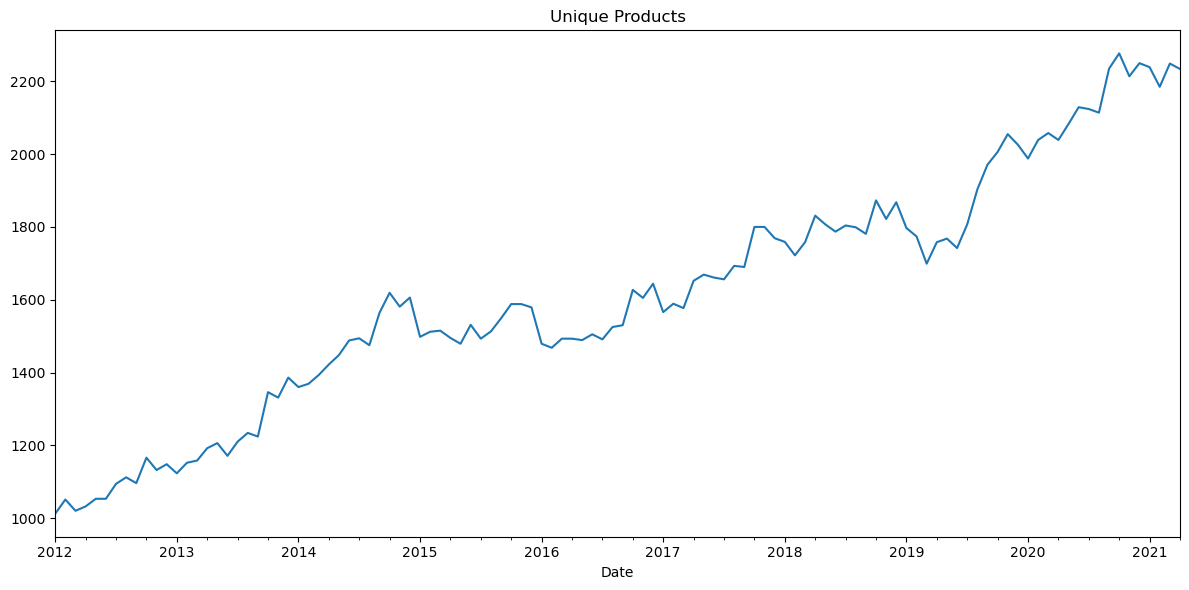

In [11]:
totalItems = sales.groupby(['ItemNumber', pd.Grouper(key='Date', freq='M')])['Sale'].sum()
totalItems = totalItems.reset_index('Date').pivot_table(index='ItemNumber', columns='Date', aggfunc=np.sum)
totalItems.columns = totalItems.columns.droplevel(0)

f,ax = plt.subplots(figsize = (12,6))
totalItems.count().plot()
ax.set_title('Unique Products')
f.tight_layout()

### Total number of products by category over time
- Whiskies are increasingly popular!
- So are Iowa distilleries

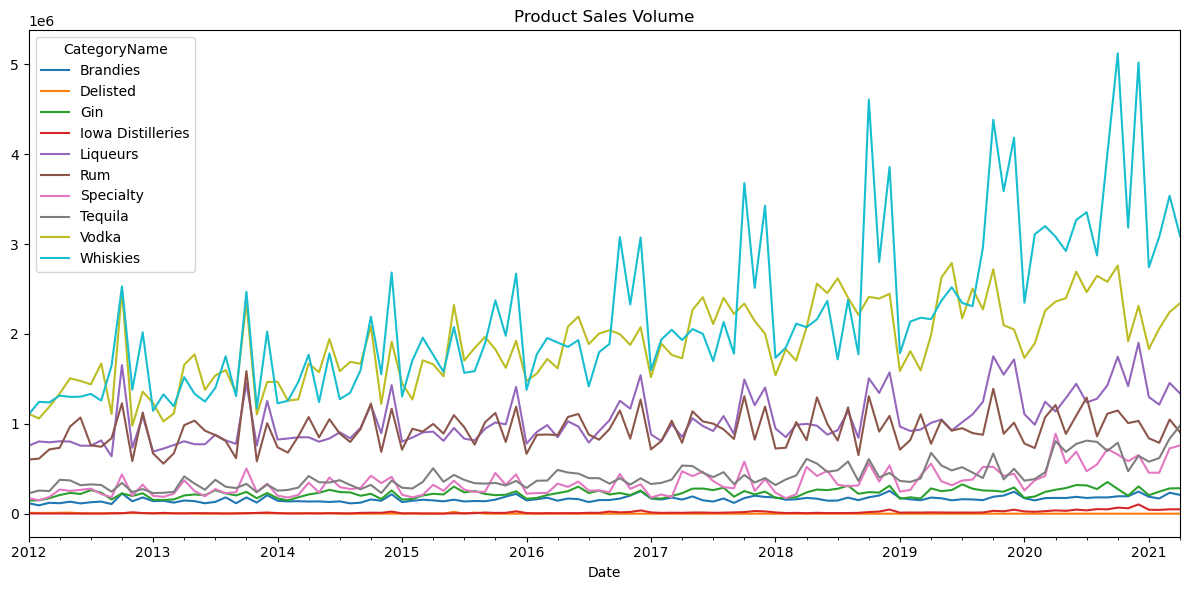

In [12]:
totalItems = sales.groupby(['CategoryName', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='CategoryName', aggfunc=np.sum)
totalItems = totalItems.fillna(0)

f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
ax.set_title('Product Sales Volume')
f.tight_layout()

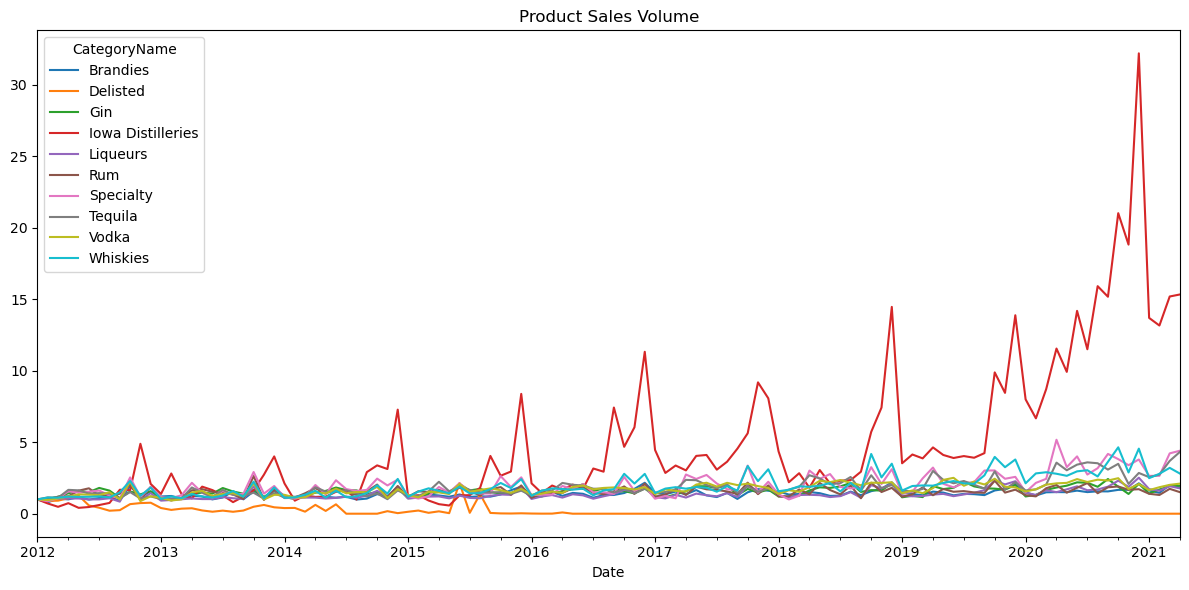

In [13]:
totalItems = sales.groupby(['CategoryName', 'ItemNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
totalItems = totalItems.reset_index('Date').pivot_table(index='Date', values='Sale', columns='CategoryName', aggfunc=np.sum)
totalItems = totalItems.fillna(0)
for col in totalItems.columns:
    totalItems[col] = totalItems[col]/totalItems[col][0]

f,ax = plt.subplots(figsize = (12,6))
totalItems.plot(ax=ax)
ax.set_title('Product Sales Volume')
f.tight_layout()

# Store Analysis
- Check store clusters based on products and location

Text(0.5, 0, 'Sales (Millions)')

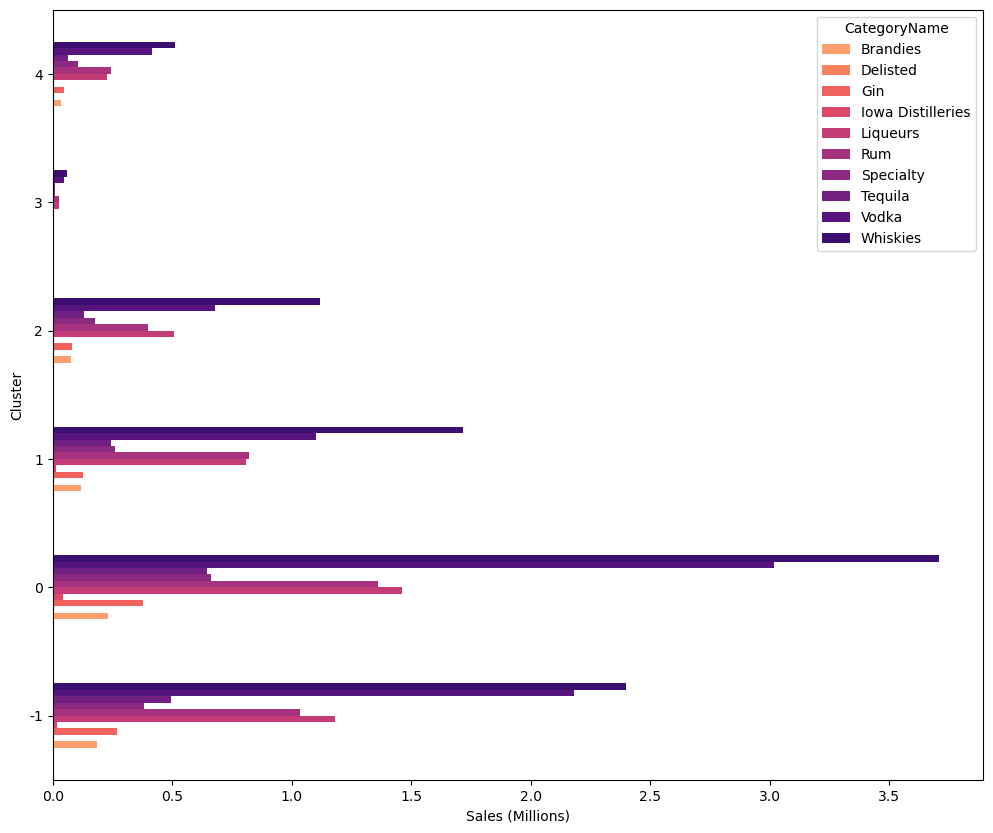

In [16]:
store_db = sales.groupby(['StoreNumber','CategoryName']).agg(Sale=('Sale','sum'),)
store_db = store_db.pivot_table(values='Sale', index='StoreNumber', columns=['CategoryName'], aggfunc=np.sum)
store_db.fillna(0, inplace=True)

import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('magma_r')
new_cmap = truncate_colormap(cmap, 0.2, 0.8)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
cluster_labels = clusterer.fit_predict(store_db,)
store_db['cluster'] = cluster_labels
cluster_sale = store_db.groupby('cluster').mean()/10**6
cluster_sale.plot(kind='barh', cmap=new_cmap, figsize=(12,10))
plt.ylabel('Cluster')
plt.xlabel('Sales (Millions)')

### Store Location

In [19]:
store_loc = sales[['StoreNumber','Latitude','Longitude']].drop_duplicates()
store_loc = store_loc.reset_index().drop(columns='Date').set_index('StoreNumber')

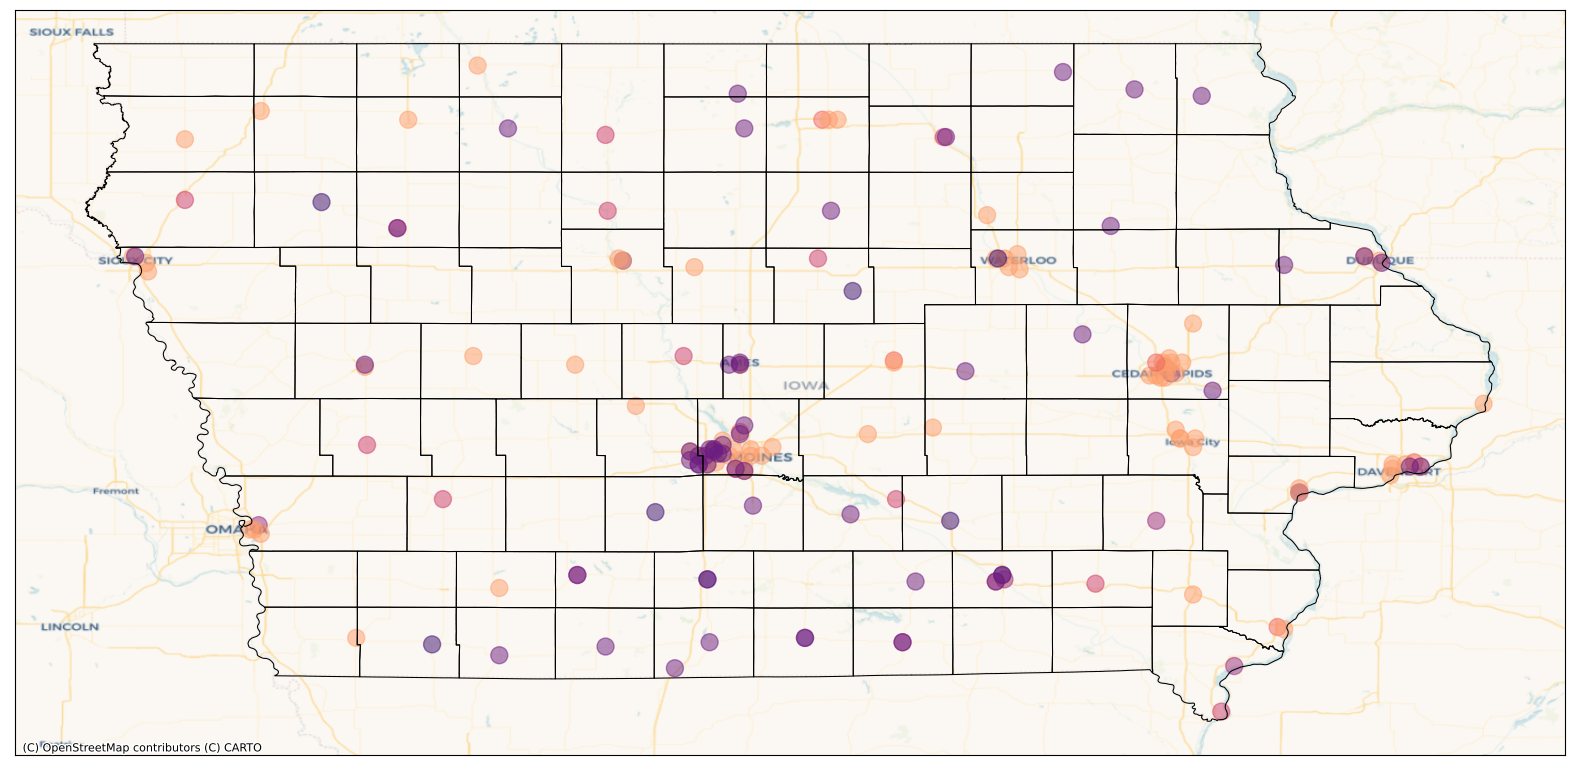

In [20]:
import geopandas
sns.color_palette("Set2")
plt.style.use('default')

import warnings
warnings.filterwarnings('ignore')

import mapclassify as mc
import math
from matplotlib import rc
import contextily as ctx

counties = geopandas.read_file('/Users/Gary/Dropbox/Projects/Liquor_Sales_Capstone_Project/data/us-county-boundaries/us-county-boundaries.shp')
counties = counties.loc[counties.statefp=='19'] # Iowa state code
counties.index = counties.namelsad.str.replace(' County','')
counties = counties[['geoid', 'geometry']]
counties.columns = ['cty_fips', 'geometry']
counties['cty_fips'] = counties['cty_fips'].astype('int32')


store_db = store_db.merge(store_loc, on='StoreNumber')
gdf = geopandas.GeoDataFrame(
    store_db, geometry=geopandas.points_from_xy(store_db.Longitude.astype(float), store_db.Latitude.astype(float)))
gdf = gdf.set_crs(epsg=4326)


ax = gdf.plot(
    column='cluster',
    cmap=new_cmap,
    markersize=150,
    alpha=0.5,
    figsize=(20,20),
)

counties.boundary.plot(
    ax=ax,
    linewidth=0.75,
    color='black'
)

#ca_shape = ca_shape.to_crs(epsg=3857)
ctx.add_basemap(ax,
                 crs=gdf.crs.to_string(),
               source=ctx.providers.CartoDB.Voyager
              )

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

### Cluster by Location

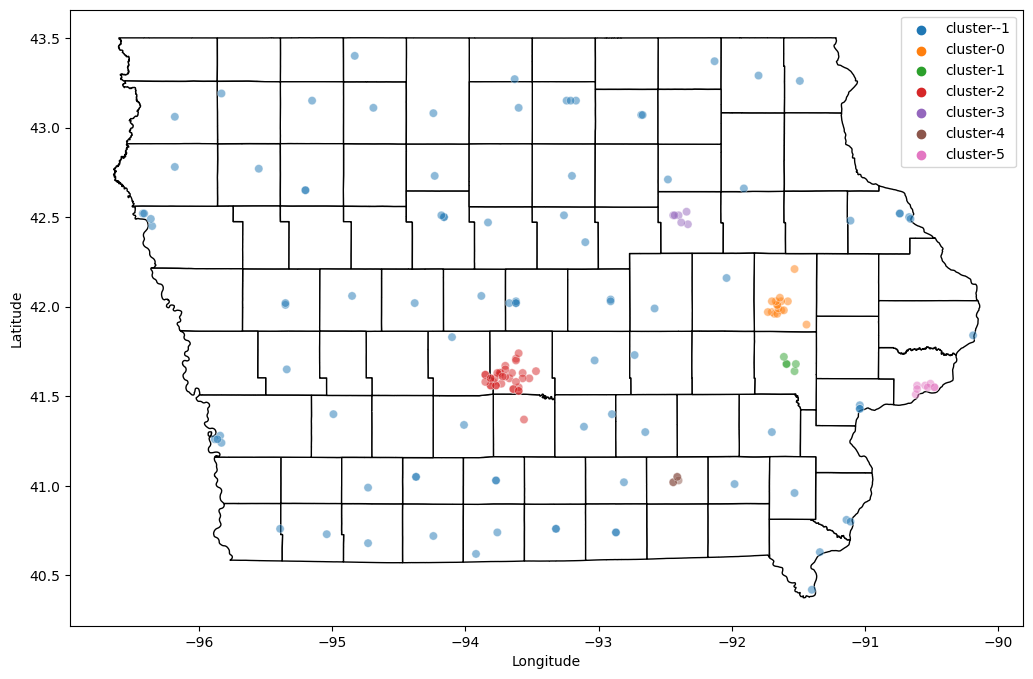

In [21]:
db = DBSCAN(eps=0.2, min_samples=5).fit(store_db[['Longitude','Latitude']])
labels = db.labels_
counties.plot(figsize=(20,8), color='white', edgecolor='black')
sns.scatterplot(store_db.loc[:,'Longitude'], 
                store_db.loc[:,'Latitude'], 
                alpha=0.5, hue=["cluster-{}".format(x) for x in labels])

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# Store Segmentation

Goal: use unsupervised learning and the Recency, Frequency, and Monetary Value (RFM) method (https://en.wikipedia.org/wiki/RFM_(market_research) to segment stores into 
- Low Value: infrequent buyers and generate low revenues
- Mid Value: somewhat fequent buyers and generate modest revenues
- High Value: frequent buyers and generate high revenues

Then create an overall score and identify the most valuable stores to dive in deeper.

In [22]:
storeDemand = sales.groupby(['StoreNumber', pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale','sum'))
storeDemand = storeDemand.pivot_table(index=['StoreNumber'], columns='Date')
storeDemand.fillna(0, inplace=True)

# Recency

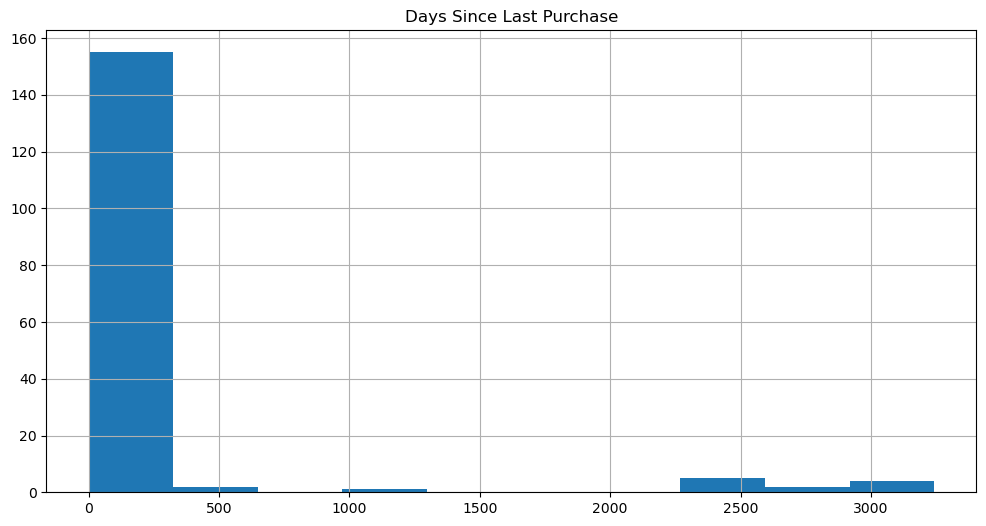

In [26]:
storeMostRecent = sales.groupby('StoreNumber').Date.max().reset_index()
storeMostRecent.columns = ['StoreNumber', 'MaxDate']
storeMostRecent['Recency'] = (storeMostRecent['MaxDate'].max() - storeMostRecent['MaxDate']).dt.days
store = pd.merge(store_loc, storeMostRecent, on='StoreNumber')
f, ax = plt.subplots(figsize = (12,6))
ax = store.Recency.hist()
ax.set_title('Days Since Last Purchase')
features = store['Recency'].to_numpy().reshape(-1,1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(storeDemand)

### Identify number of clusters for grouping stores
- Use elbow method
- Elbow occurs at 4. Choose 4 clusters.

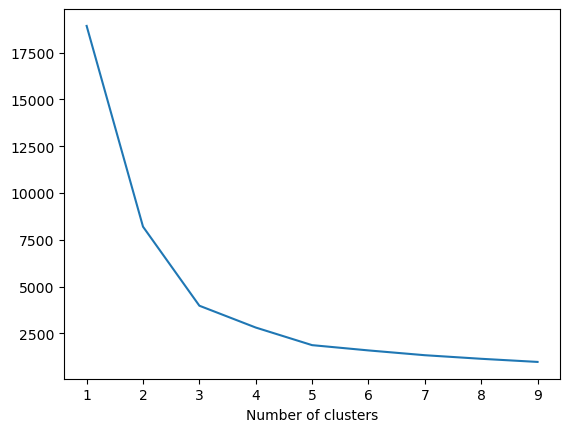

In [27]:
rng = np.random.RandomState(42)
sse={}
kmeans_features = scaled_features
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, 
                    max_iter=1000,
                    random_state=rng).fit(kmeans_features)
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [28]:
kmeans = KMeans(
    init='random',
    n_clusters=4,
    n_init=10,
    max_iter=1000,
    random_state=rng
)

### Set clusters and then label stores

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

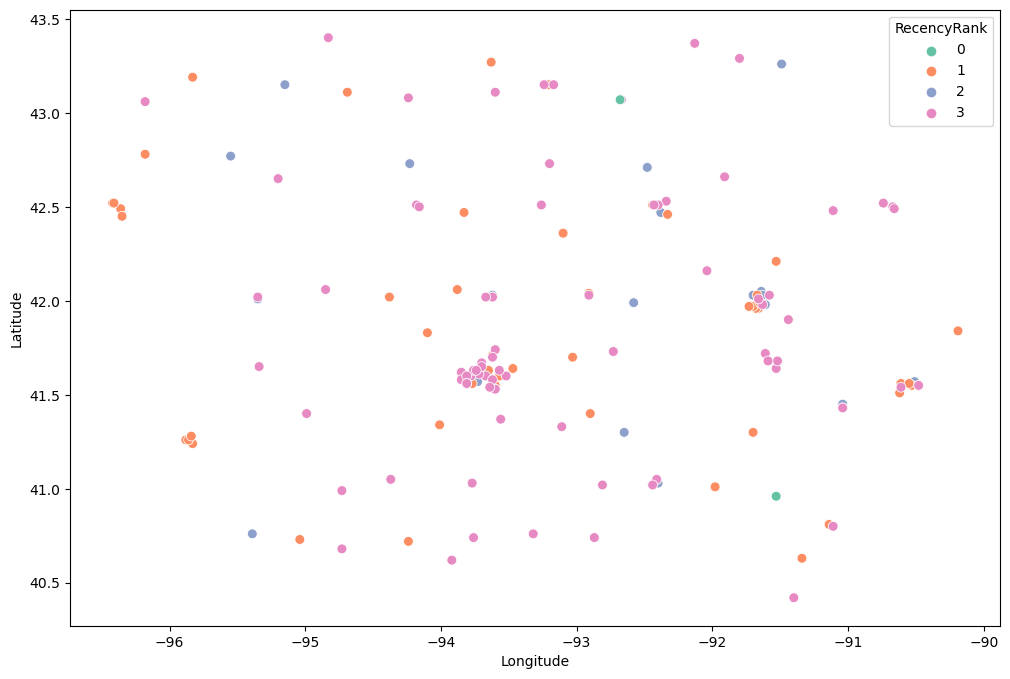

In [29]:
kmeans.fit(scaled_features)
storeCols = list(store.columns.values) + ['RecencyCluster']
RecencyCluster = pd.concat([store, pd.Series(kmeans.labels_)], axis=1)
RecencyCluster.columns = storeCols

RecencyRanking = RecencyCluster.groupby('RecencyCluster').Recency.describe().sort_values(by='mean', ascending=True)
RecencyRanking = RecencyRanking.reset_index().reset_index()
RecencyRanking = RecencyRanking.loc[:,['index','RecencyCluster','mean']]
RecencyRanking.columns = ['RecencyRank','RecencyCluster','RecencyMean']
RecencyCluster = pd.merge(RecencyCluster, RecencyRanking, on='RecencyCluster')
plt.figure(figsize=(12, 8))
sns.scatterplot(
    s=50,
    data=RecencyCluster,
    x='Longitude',
    y='Latitude',
    hue="RecencyRank",
    palette="Set2"
)

<AxesSubplot:xlabel='RecencyRank', ylabel='Days inactive'>

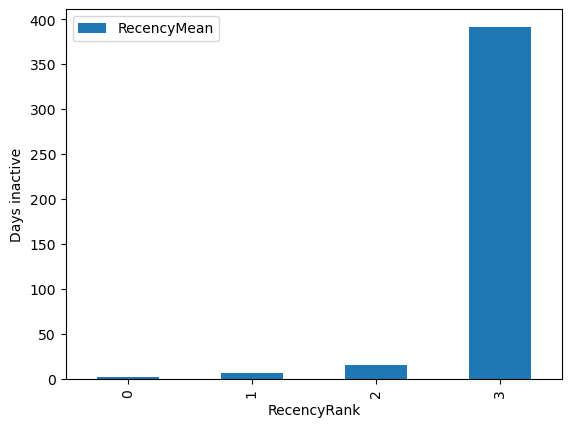

In [30]:
RecencyCluster.groupby('RecencyRank').agg(RecencyMean=('RecencyMean','mean')).plot(kind='bar', ylabel='Days inactive')

## Frequency

Text(0.5, 1.0, 'Frequency')

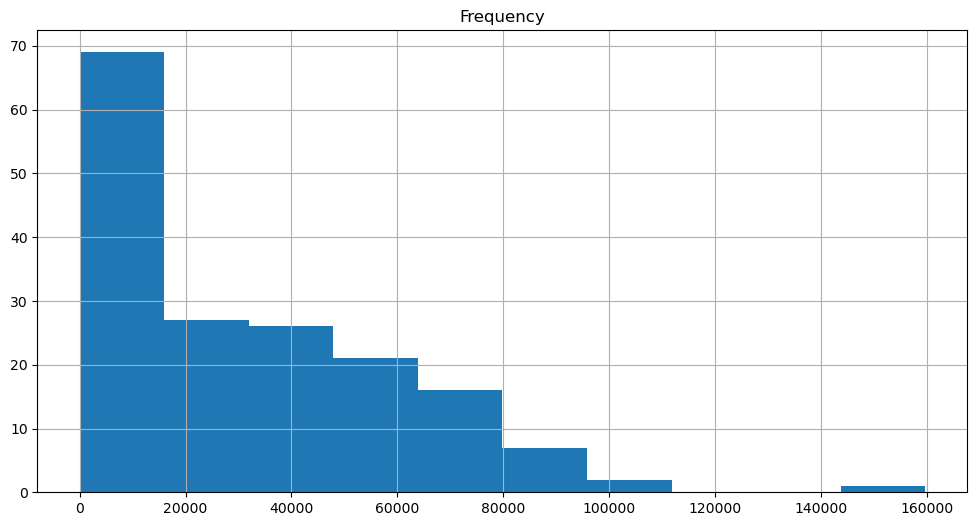

In [31]:
storeFrequency = sales.groupby('StoreNumber').Sale.count().reset_index()
storeFrequency.columns = ['StoreNumber', 'Frequency']
store = pd.merge(store_loc, storeFrequency, on ='StoreNumber')
f, ax = plt.subplots(figsize=(12,6))
ax = store.Frequency.hist()
ax.set_title('Frequency')

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

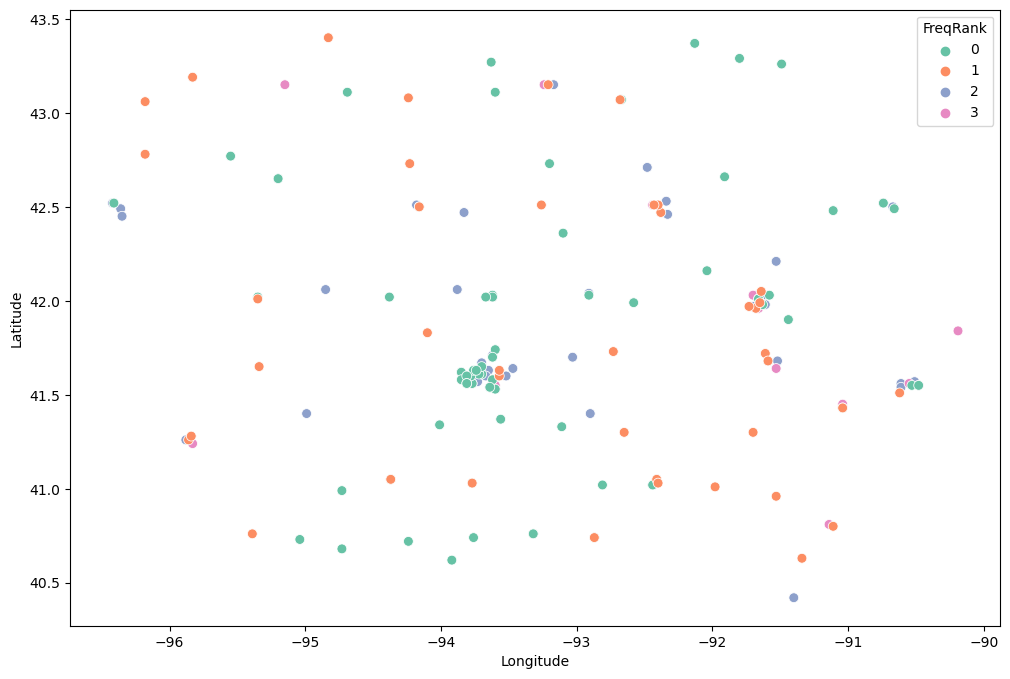

In [32]:
features = store['Frequency'].to_numpy().reshape(-1,1)
scaled_features = scaler.fit_transform(features)
kmeans.fit(scaled_features)

storeCols = list(store.columns.values) + ['FreqCluster']
FreqCluster = pd.concat([store, pd.Series(kmeans.labels_)], axis=1)
FreqCluster.columns = storeCols

FreqRanking = FreqCluster.groupby('FreqCluster').Frequency.describe().sort_values(by='mean')
FreqRanking = FreqRanking.reset_index().reset_index()
FreqRanking = FreqRanking.loc[:,['index','FreqCluster','mean']]
FreqRanking.columns = ['FreqRank','FreqCluster','FreqMean']
FreqCluster = pd.merge(FreqCluster, FreqRanking, on='FreqCluster')

plt.figure(figsize=(12, 8))
sns.scatterplot(
    s=50,
    data=FreqCluster,
    x='Longitude',
    y='Latitude',
    hue="FreqRank",
    palette="Set2"
)

<AxesSubplot:xlabel='FreqRank', ylabel='Number of transactions'>

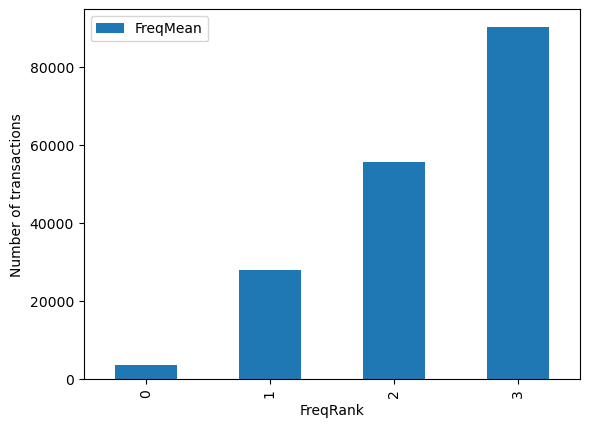

In [33]:
FreqCluster.groupby('FreqRank').agg(FreqMean=('FreqMean','mean')).plot(kind='bar', ylabel='Number of transactions')

## Sale Volume

Text(0.5, 1.0, 'Value')

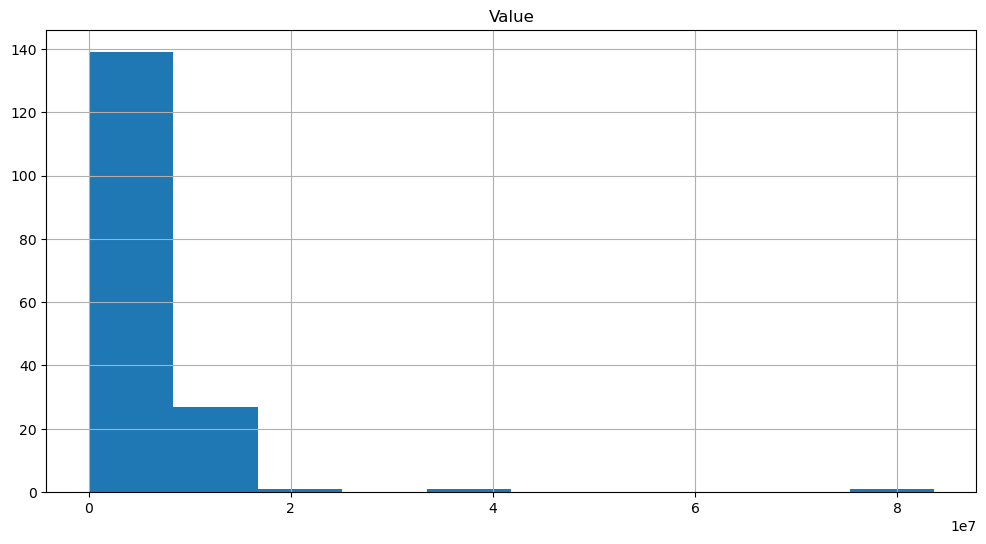

In [34]:
storeSale = sales.groupby('StoreNumber').Sale.sum().reset_index()
storeSale.columns = ['StoreNumber', 'Value']
store = pd.merge(store_loc, storeSale, on ='StoreNumber')
f, ax = plt.subplots(figsize=(12,6))
ax = store.Value.hist()
ax.set_title('Value')

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

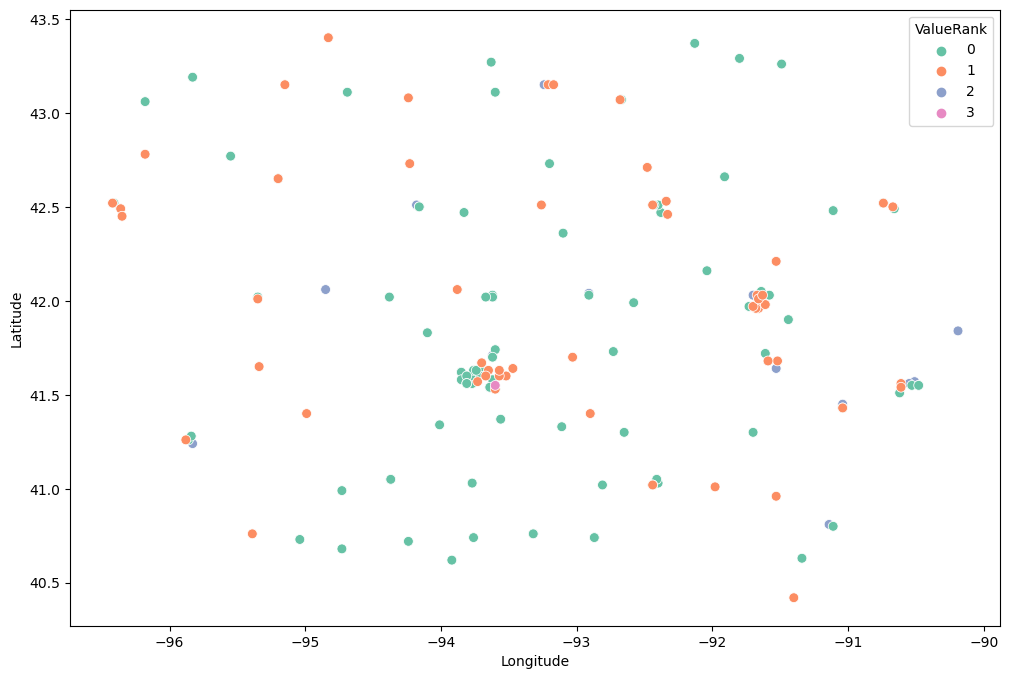

In [35]:
features = store['Value'].to_numpy().reshape(-1,1)
scaled_features = scaler.fit_transform(features)
kmeans.fit(scaled_features)

storeCols = list(store.columns.values) + ['ValueCluster']
ValueCluster = pd.concat([store, pd.Series(kmeans.labels_)], axis=1)
ValueCluster.columns = storeCols

ValueRanking = ValueCluster.groupby('ValueCluster').Value.describe().sort_values(by='mean')
ValueRanking = ValueRanking.reset_index().reset_index()
ValueRanking = ValueRanking.loc[:,['index','ValueCluster','mean']]
ValueRanking.columns = ['ValueRank','ValueCluster','ValueMean']

ValueCluster = pd.merge(ValueCluster,ValueRanking, on = 'ValueCluster')

plt.figure(figsize=(12, 8))
sns.scatterplot(
    s=50,
    data=ValueCluster,
    x='Longitude',
    y='Latitude',
    hue="ValueRank",
    palette="Set2"
)

<AxesSubplot:xlabel='ValueRank', ylabel='Total Sale Volume'>

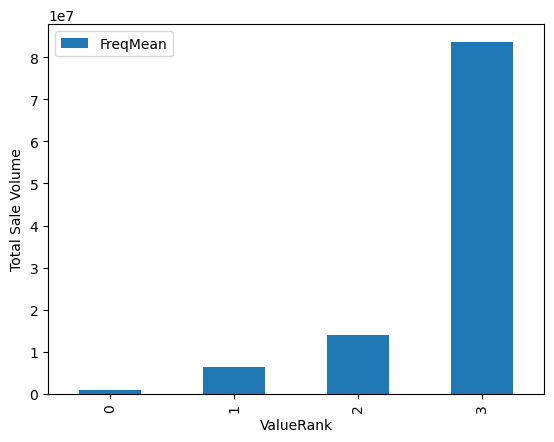

In [36]:
ValueCluster.groupby('ValueRank').agg(FreqMean=('ValueMean','mean')).plot(kind='bar', ylabel='Total Sale Volume')

## Overall Score

In [61]:
final_score = pd.merge(store, RecencyCluster[['StoreNumber','RecencyRank']], on='StoreNumber')
final_score = pd.merge(final_score, FreqCluster[['StoreNumber','FreqRank']], on='StoreNumber')
final_score = pd.merge(final_score, ValueCluster[['StoreNumber','ValueRank']], on='StoreNumber')

final_score['OverallScore'] =  final_score['RecencyRank'] + final_score['FreqRank'] + final_score['ValueRank']
final_score['CustomerSegment'] = '1 Low-Value'
final_score.loc[final_score['OverallScore']>2, 'CustomerSegment'] = '2 Mid-Value'
final_score.loc[final_score['OverallScore']>4, 'CustomerSegment'] = '3 High-Value'

Text(0.5, 0, 'Sale Volume (Millions)')

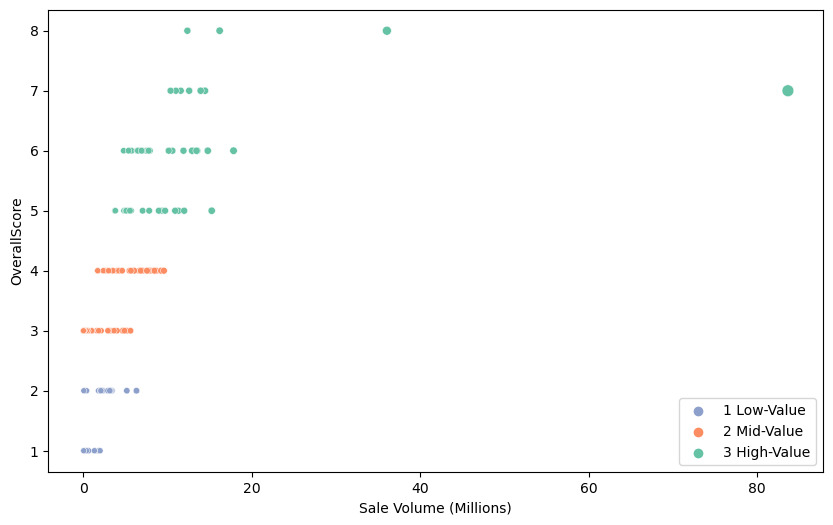

In [62]:
f, ax = plt.subplots(figsize=(10, 6))
final_score.Value = final_score.Value/10**6
sns.scatterplot(
    data=final_score,
    y='OverallScore',
    x='Value',
    hue='CustomerSegment',
    size=final_score['Value'],
    palette='Set2',
    ax=ax
)

handles,labels = ax.get_legend_handles_labels()

handles = [handles[3], handles[2], handles[1]]
labels = [labels[3], labels[2], labels[1]]

ax.legend(handles,labels,loc=4)
ax.set_xlabel('Overall Score')
ax.set_xlabel('Sale Volume (Millions)')

Which stores are the high value ones?
- StoreNumber: 2633

In [63]:
final_score[(final_score.Value>40) & (final_score.OverallScore>=7)]

StoreNumber  Latitude  Longitude      Value  RecencyRank  FreqRank  \
65         2633     41.55      -93.6  83.648642            1         3   

    ValueRank  OverallScore CustomerSegment  
65          3             7    3 High-Value

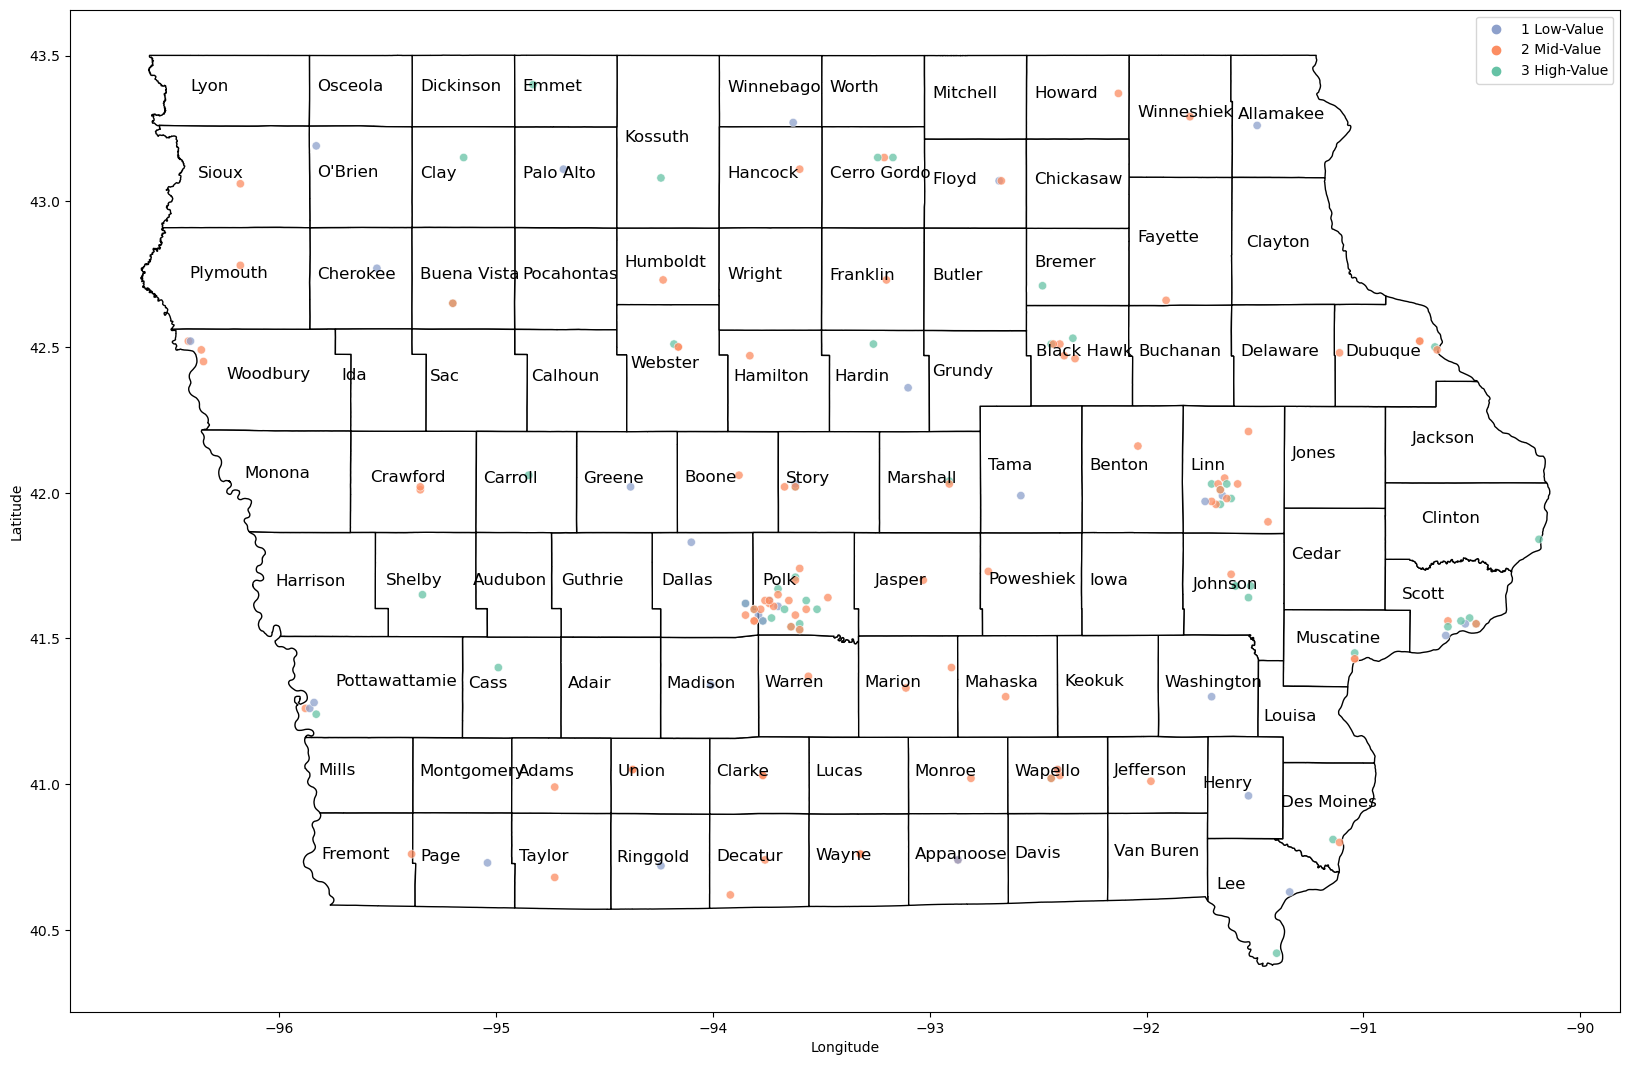

In [67]:
f, ax = plt.subplots(figsize=(20, 15))
counties.plot(color='white', edgecolor='black', ax=ax)
sns.scatterplot(
    data=final_score,
    x='Longitude',
    y='Latitude',
    hue='CustomerSegment',
    palette='Set2',
    alpha=0.75,
    sizes=50,
    ax=ax,
)

handles,labels = ax.get_legend_handles_labels()

handles = [handles[2], handles[1], handles[0]]
labels = [labels[2], labels[1], labels[0]]

ax.legend(handles,labels,loc=1)

counties = geopandas.read_file('/Users/Gary/Dropbox/Projects/Liquor_Sales_Capstone_Project/data/us-county-boundaries/us-county-boundaries.shp')
counties = counties[counties.statefp=='19'] # Iowa state code
counties.namelsad = counties.namelsad.str.replace(' County','')
counties = counties[['namelsad', 'geoid', 'geometry']]
counties.columns = ['name', 'cty_fips', 'geometry']
for name in counties.name:
    x = counties[counties.name==name].geometry.centroid.x-0.2
    y = counties[counties.name==name].geometry.centroid.y
    plt.annotate(name, (x, y), fontsize=12)

In [68]:
xlsx_path = 'https://www2.census.gov/programs-surveys/popest/tables/2010-2019/counties/totals/co-est2019-annres-19.xlsx'
iowa_pop = pd.read_excel(xlsx_path, skiprows=3,skipfooter=5)
iowa_pop = iowa_pop.loc[1:]
iowa_pop.columns = ['County' if i == 'Unnamed: 0' else i for i in iowa_pop.columns]
iowa_pop['County'] = [i.replace('.', '') for i in iowa_pop.County]

In [69]:
unique_stores = sales[sales.index.year==2019]
unique_stores = unique_stores.reset_index(drop=True)[['StoreNumber','County']].drop_duplicates()
unique_stores = unique_stores.reset_index(drop=True)
unique_stores.loc[unique_stores['County']=='Buena Vist', 'County'] = 'Buena Vista'
unique_stores.loc[unique_stores['County']=='Pottawatta', 'County'] = 'Pottawattamie'
unique_stores.loc[unique_stores['County']=='Obrien', 'County'] = "O'Brien"
unique_stores.loc[unique_stores['County']=='Cerro Gord', 'County'] = "Cerro Gordo"
print(unique_stores.shape)
unique_stores['County'] = unique_stores['County'] + " County, Iowa"
unique_stores = unique_stores.merge(iowa_pop, left_on='County', right_on='County')
print(unique_stores.shape)
unique_stores.County = unique_stores.County.str.replace('County, Iowa','').str.strip()
unique_stores.index = unique_stores.County
unique_stores.drop(columns='County',inplace=True)
unique_stores.columns = [str(i) for i in unique_stores.columns]
unique_stores = unique_stores.groupby('County').agg(
    Freq=('2019','count'), 
    Pop2019=('2019', 'mean')
)
unique_stores['store_per_1000pop'] = unique_stores['Freq']/unique_stores['Pop2019'] * 1000

(136, 2)
(136, 14)


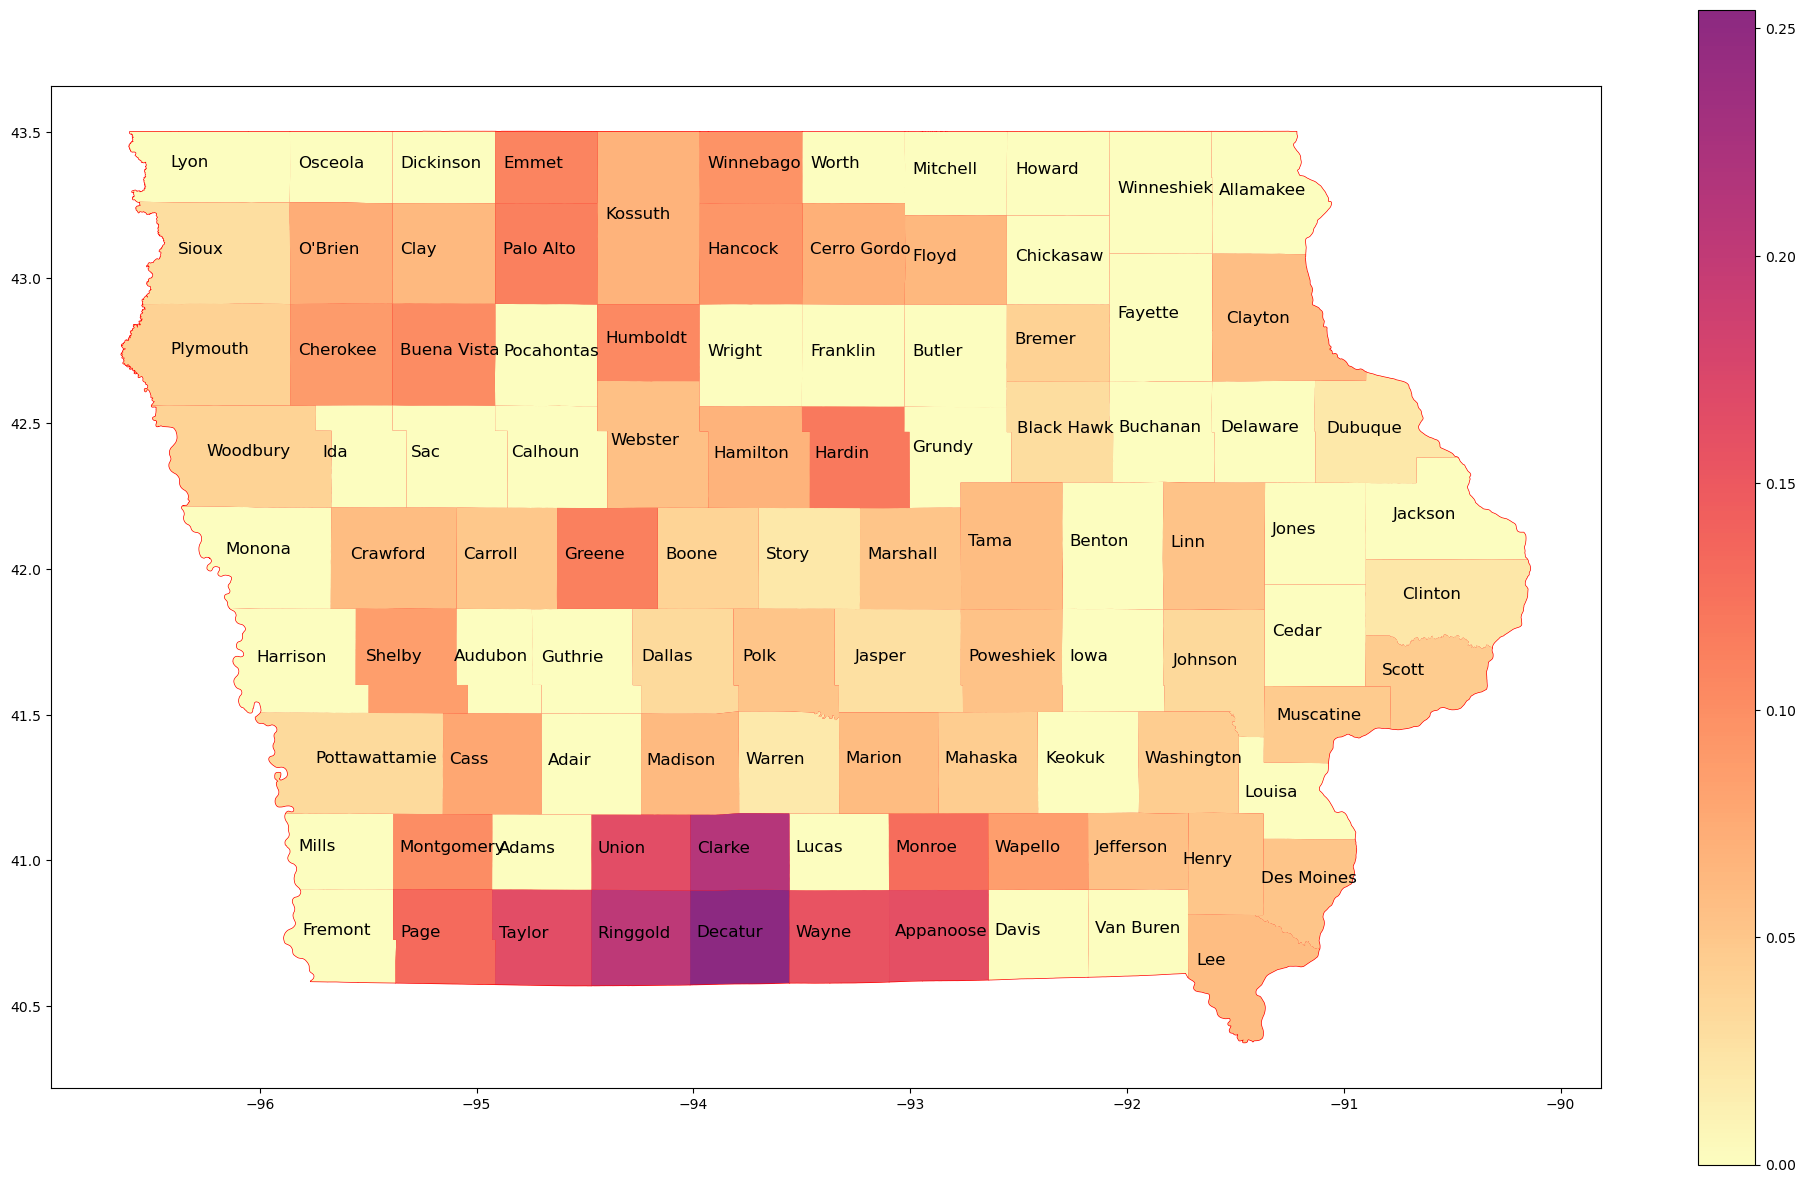

In [70]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('magma_r')
new_cmap = truncate_colormap(cmap, 0, 0.6)

# Stores per 1000pop (County level)
store_per_1000pop_counties = counties.reset_index().merge(
    unique_stores.reset_index(), 
    right_on='County', 
    left_on='name',
    how='left',
)
store_per_1000pop_counties.fillna(0, inplace=True)
fig, ax = plt.subplots(1, 1,  figsize=(25,15))
store_per_1000pop_counties.plot(color='white', edgecolor='red', ax=ax)
store_per_1000pop_counties.plot(column='store_per_1000pop', cmap=new_cmap, ax=ax, legend=True)

loc = geopandas.read_file('/Users/Gary/Dropbox/Projects/Liquor_Sales_Capstone_Project/data/us-county-boundaries/us-county-boundaries.shp')
loc = loc[loc.statefp=='19'] # Iowa state code
loc.namelsad = loc.namelsad.str.replace(' County','')
loc = loc[['namelsad', 'geoid', 'geometry']]
loc.columns = ['name', 'cty_fips', 'geometry']
for name in loc.name:
    x = loc[loc.name==name].geometry.centroid.x-0.2
    y = loc[loc.name==name].geometry.centroid.y
    plt.annotate(name, (x, y), fontsize=12)

# Market Basket Analysis Using Highest Value Store
- Identify top 100 items with highest sales
- Then perform MBA

In [7]:
conn = sqlite3.connect('IowaLiquor.db')
product_name = pd.read_sql_query(
    "SELECT ItemNumber, ItemDescription from Item", conn
)
product_name = product_name.astype(str)

In [40]:
item = sales.groupby('ItemNumber').sum().sort_values(by='Sale', ascending=False)
item = item.reset_index()[['ItemNumber', 'Sale']]
item = item.sort_values(by='Sale', ascending=False)
item = item.loc[0:100,]
item.drop(columns='Sale', inplace=True)
item = item.astype(str)
item = item.merge(product_name, on='ItemNumber')

In [41]:
store = sales[sales.StoreNumber==2633]
store.ItemNumber = store.ItemNumber.astype(str)
store = store.merge(item.reset_index()['ItemNumber'], on='ItemNumber')
store = store.groupby(['ItemNumber', 'ItemDescription',pd.Grouper(key = 'Date', freq='W')]).agg(Sale=('Sale','sum'))
store = store.pivot_table(values='Sale', index=['Date'], columns=['ItemNumber','ItemDescription'], aggfunc=np.sum)
store.fillna(0, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [42]:
for col in store.columns:
    store.loc[store[col]>0, col] = 1
store = store.astype(int)
store

ItemNumber                     10628               10791  \
ItemDescription Canadian Club Whisky Crown Royal Vanilla   
Date                                                       
2012-01-08                         1                   0   
2012-01-15                         0                   0   
2012-01-22                         0                   0   
2012-01-29                         1                   0   
2012-02-05                         0                   0   
...                              ...                 ...   
2021-04-04                         0                   0   
2021-04-11                         0                   0   
2021-04-18                         0                   0   
2021-04-25                         0                   0   
2021-05-02                         0                   0   

ItemNumber                        10807       11296       11297       11298  \
ItemDescription Crown Royal Regal Apple Crown Royal Crown Royal Crown Royal   
Date                                                                          
2012-01-08                            0           0           0           1   
2012-01-15                            0           0           0           1   
2012-01-22                            0           0           0           1   
2012-01-29                            0           0           1           1   
2012-02-05                            0           0           1           0   
...                                 ...         ...         ...         ...   
2021-04-04                            0           0           1           0   
2021-04-11                            1           0           1           0   
2021-04-18                            0           0           1           0   
2021-04-25                            1           0           1           0   
2021-05-02                            1           0           1           0   

ItemNumber             11788               12408   15626   15627  ...  \
ItemDescription Black Velvet Canadian Ltd Whisky Jameson Jameson  ...   
Date                                                              ...   
2012-01-08                 0                   0       1       1  ...   
2012-01-15                 0                   0       0       1  ...   
2012-01-22                 0                   0       0       1  ...   
2012-01-29                 0                   0       1       1  ...   
2012-02-05                 0                   0       0       1  ...   
...                      ...                 ...     ...     ...  ...   
2021-04-04                 0                   0       1       0  ...   
2021-04-11                 0                   0       1       0  ...   
2021-04-18                 1                   0       1       1  ...   
2021-04-25                 0                   0       0       1  ...   
2021-05-02                 1                   0       0       1  ...   

ItemNumber                             68037                   69637  \
ItemDescription Baileys Original Irish Cream Dr McGillicuddys Cherry   
Date                                                                   
2012-01-08                                 0                       1   
2012-01-15                                 0                       1   
2012-01-22                                 0                       1   
2012-01-29                                 1                       1   
2012-02-05                                 1                       1   
...                                      ...                     ...   
2021-04-04                                 0                       1   
2021-04-11                                 1                       0   
2021-04-18                                 0                       1   
2021-04-25                                 0                       1   
2021-05-02                                 0                       1   

ItemNumber          

In [43]:
freq_itemsets = apriori(store, min_support=0.5, use_colnames=True, max_len=2)
rules = association_rules(freq_itemsets, metric="lift")
rules[(rules['lift']>.6) & (rules['confidence']>0.8)]

antecedents  \
1                      ((11297, Crown Royal))   
3                      ((11297, Crown Royal))   
4                      ((11297, Crown Royal))   
6                      ((11297, Crown Royal))   
10                     ((11297, Crown Royal))   
..                                        ...   
929  ((89197, Jose Cuervo Especial Reposado))   
930    ((82847, Dekuyper Luscious Peachtree))   
931                    ((89387, Juarez Gold))   
932                    ((89387, Juarez Gold))   
933  ((89197, Jose Cuervo Especial Reposado))   

                                  consequents  antecedent support  \
1                         ((19067, Jim Beam))            0.672840   
3                      ((19477, Makers Mark))            0.672840   
4                 ((25607, Seagrams 7 Crown))            0.672840   
6                    ((28867, Tanqueray Gin))            0.672840   
10                  ((34029, Absolut Citron))            0.672840   
..                                        ...                 ...   
929    ((82847, Dekuyper Luscious Peachtree))            0.878601   
930                    ((89387, Juarez Gold))            0.948560   
931    ((82847, Dekuyper Luscious Peachtree))            0.845679   
932  ((89197, Jose Cuervo Especial Reposado))            0.845679   
933                    ((89387, Juarez Gold))            0.878601   

     consequent support   support  confidence      lift  leverage  conviction  
1              0.862140  0.600823    0.892966  1.035756  0.020741    1.288007  
3              0.870370  0.596708    0.886850  1.018934  0.011088    1.145646  
4              0.905350  0.623457    0.926606  1.023478  0.014302    1.289609  
6              0.971193  0.668724    0.993884  1.023363  0.015267    4.709877  
10             0.907407  0.641975    0.954128  1.051488  0.031436    2.018519  
..                  ...       ...         ...       ...       ...         ...  
929            0.948560  0.841564    0.957845  1.009789  0.008158    1.220279  
930            0.845679  0.808642    0.852495  1.008059  0.006465    1.046206  
931            0.948560  0.808642    0.956204  1.008059  0.006465    1.174554  
932            0.878601  0.759259    0.897810  1.021864  0.016245    1.187978  
933            0.845679  0.759259    0.864169  1.021864  0.016245    1.136122  

[669 rows x 9 columns]

In [44]:
rules.sort_values('confidence', ascending = False, inplace = True)
rules[['antecedents', 'consequents','confidence']].head(20)

antecedents  \
587                  ((37348, Phillips Vodka))   
570                    ((35317, Barton Vodka))   
612    ((68037, Baileys Original Irish Cream))   
186             ((17206, Cedar Ridge Bourbon))   
6                       ((11297, Crown Royal))   
820  ((43338, Captain Morgan Original Spiced))   
576                    ((35317, Barton Vodka))   
142                ((16676, Basil Hayden 8YR))   
154             ((17206, Cedar Ridge Bourbon))   
162             ((17206, Cedar Ridge Bourbon))   
801  ((43337, Captain Morgan Original Spiced))   
202                        ((19067, Jim Beam))   
374               ((27102, Templeton Rye 4YR))   
350               ((27102, Templeton Rye 4YR))   
356               ((27102, Templeton Rye 4YR))   
402            ((38177, Titos Handmade Vodka))   
130                         ((15627, Jameson))   
387                  ((34029, Absolut Citron))   
62                      ((11298, Crown Royal))   
404            ((38178, Titos Handmade Vodka))   

                                           consequents  confidence  
587                           ((36307, Hawkeye Vodka))    0.996324  
570                           ((36307, Hawkeye Vodka))    0.996296  
612                           ((36307, Hawkeye Vodka))    0.995157  
186                 ((69637, Dr McGillicuddys Cherry))    0.994398  
6                             ((28867, Tanqueray Gin))    0.993884  
820                 ((69637, Dr McGillicuddys Cherry))    0.992629  
576                 ((69637, Dr McGillicuddys Cherry))    0.992593  
142                           ((36307, Hawkeye Vodka))    0.991870  
154                           ((28867, Tanqueray Gin))    0.991597  
162                           ((36307, Hawkeye Vodka))    0.991597  
801  ((69947, Rumple Minze Peppermint Schnapps Liqu...    0.991098  
202                           ((28867, Tanqueray Gin))    0.990453  
374                 ((69637, Dr McGillicuddys Cherry))    0.990228  
350                           ((28867, Tanqueray Gin))    0.990228  
356                           ((36307, Hawkeye Vodka))    0.990228  
402                           ((28867, Tanqueray Gin))    0.990164  
130                 ((69637, Dr McGillicuddys Cherry))    0.990000  
387                           ((28867, Tanqueray Gin))    0.988662  
62                            ((36307, Hawkeye Vodka))    0.988473  
404                           ((28867, Tanqueray Gin))    0.988000

# Introducing Time Series

- Demand forcasting
- Forecast recovery

In [224]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from dateutil.parser import parse

plt.rcParams.update({'figure.figsize': (6,8)})

# Monthly sales data
sales = pd.read_csv('hy-vee.csv')
sales.drop(columns='Unnamed: 0', inplace=True)
sales['Date'] = pd.to_datetime(sales['Date'], format='%m/%d/%Y', errors='ignore')
sales.index = sales.Date
sales.Sale = sales.Sale/10**6

# Remove years prior to 2014 since there was a lot more variance in sales
sales = sales[sales.index.year>=2014]
allstores = sales.groupby(pd.Grouper(key = 'Date', freq='M')).agg(sales=('Sale','sum'))
highval = sales[sales.StoreNumber==2633].groupby(pd.Grouper(key = 'Date', freq='M')).agg(sales=('Sale','sum'))

### Check seasonality - additive decomposition seems to work better.
- Residual looks random and centered around zero for additive decomposition model.

Text(0.6, 1, 'All Hy-Vee Stores')

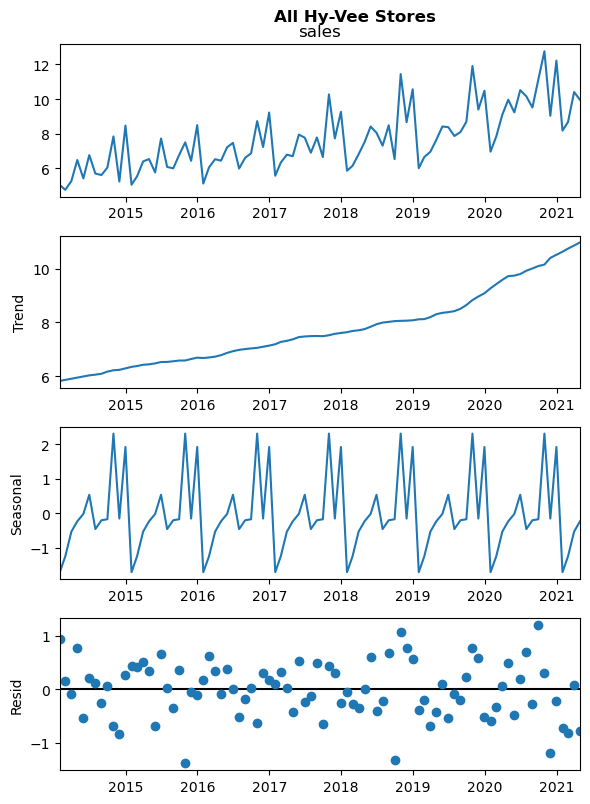

In [225]:
allstore_decomp = seasonal_decompose(allstores['sales'], model='additive', extrapolate_trend='freq')
allstore_decomp.plot().suptitle('All Hy-Vee Stores', fontsize=12,y=1,x=0.6,fontweight='bold')

Text(0.6, 1, 'High-value store')

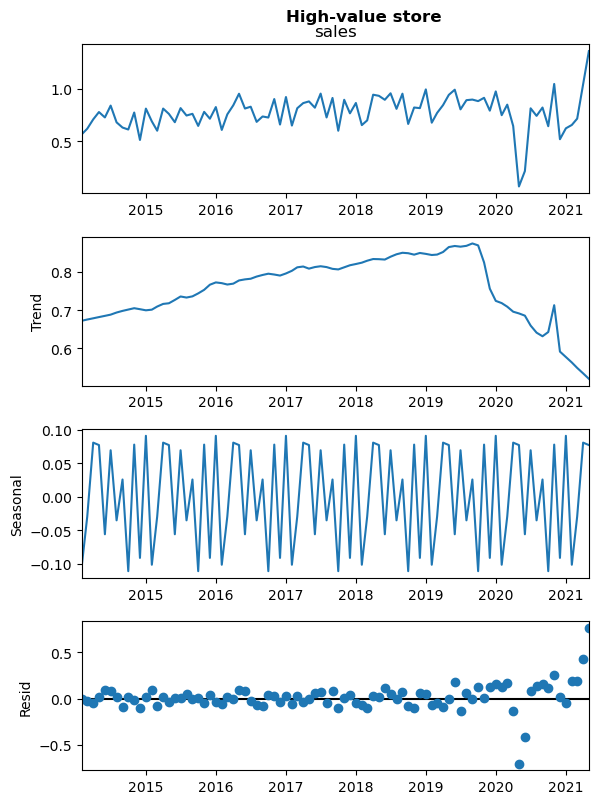

In [226]:
highval_decomp = seasonal_decompose(highval['sales'], model='additive', extrapolate_trend='freq')
highval_decomp.plot().suptitle('High-value store', fontsize=12,y=1,x=0.6,fontweight='bold')

### Check stationarity
- Stationarity is a property of a time series. A stationary series is one where the values of the series is not a function of time. In other words, statistical properties of the series like mean, variance and autocorrelation are constant over time.


### Tests
- Unit root test (Augmented Dickey Fuller test): null hypothesis is the time series possesses a unit root and is non-stationary. When P-Value in ADH test is less than the significance level chosen, reject the null hypothesis and the series is assumed to be stationary.
- Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary): null hypothesis is that the trend is stationary. When the p-value in the kPSS test is less than the significance level chosen, reject the null and assume the series is non-stationary (opposite of the interpretatin of ADF).

In [227]:
# ADF Test
result = adfuller(allstores.sales.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
if result[1]<0.05:
    print(f'Since p-value {result[1]} is less than 0.05 critical value, ADF null is rejected and series is stationary.')
else:
    print('Null hypothesis of ADF is not rejected. Series is not stationary.')

# KPSS Test
result = kpss(allstores.sales.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
if result[1]<0.05:
    print(f'Since p-value {result[1]} is less than 0.05 critical value, KPSS null is rejected and series is NOT stationary.')
else:
    print('Null hypothesis of KPSS is not rejected. Series is stationary.')    

ADF Statistic: 3.113198740520717
p-value: 1.0
Critial Values:
   1%, -3.5194805351545413
Critial Values:
   5%, -2.9003945086747343
Critial Values:
   10%, -2.5874984279778395
Null hypothesis of ADF is not rejected. Series is not stationary.

KPSS Statistic: 0.759582
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739
Since p-value 0.01 is less than 0.05 critical value, KPSS null is rejected and series is NOT stationary.


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)


### Removing trends and seasonality

Text(0.5, 1.0, 'De-trended Drug Sales')

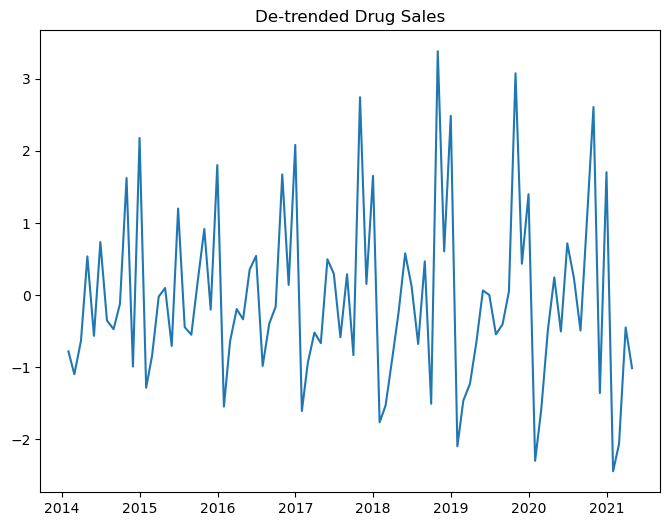

In [228]:
plt.rcParams.update({'figure.figsize': (8,6)})

detrended = allstores.sales.values - allstore_decomp.trend
plt.plot(detrended)
plt.title('De-trended Drug Sales', fontsize=12)

Text(0.5, 1.0, 'De-seasonal Drug Sales')

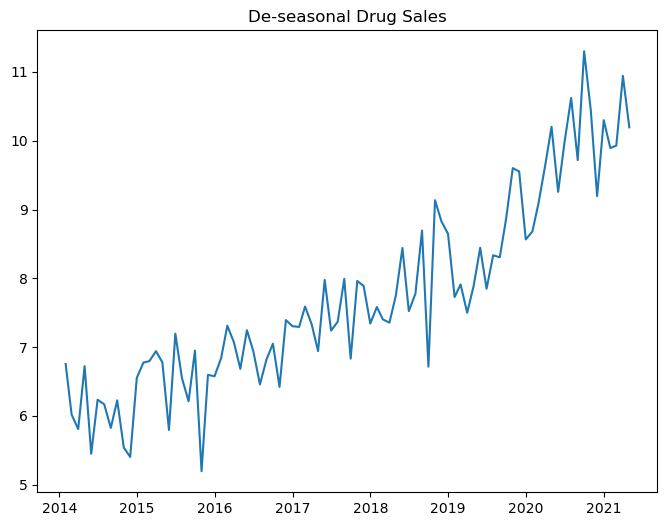

In [229]:
deseasonal = allstores.sales.values - allstore_decomp.seasonal
plt.plot(deseasonal)
plt.title('De-seasonal Drug Sales', fontsize=12)

### Autocorrelation decraeses and plateaus around 300 lag before increasing again

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

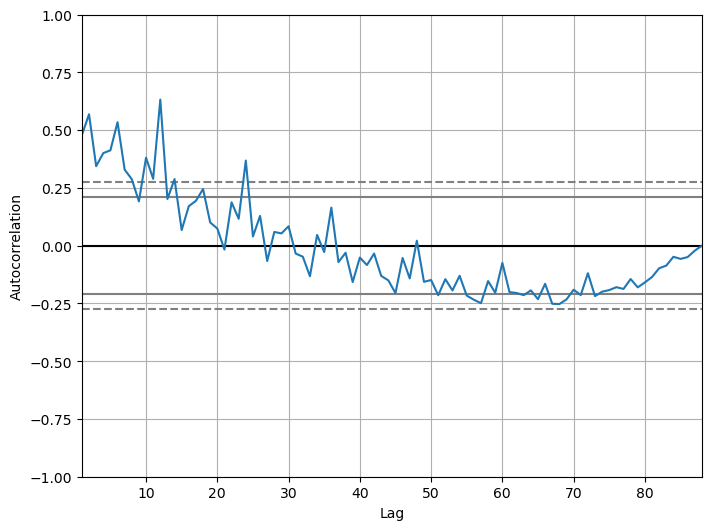

In [230]:
autocorrelation_plot(allstores.sales.tolist())

### Order of differencing (d)
- Series appears stationary after first-differencing
- Set d=1

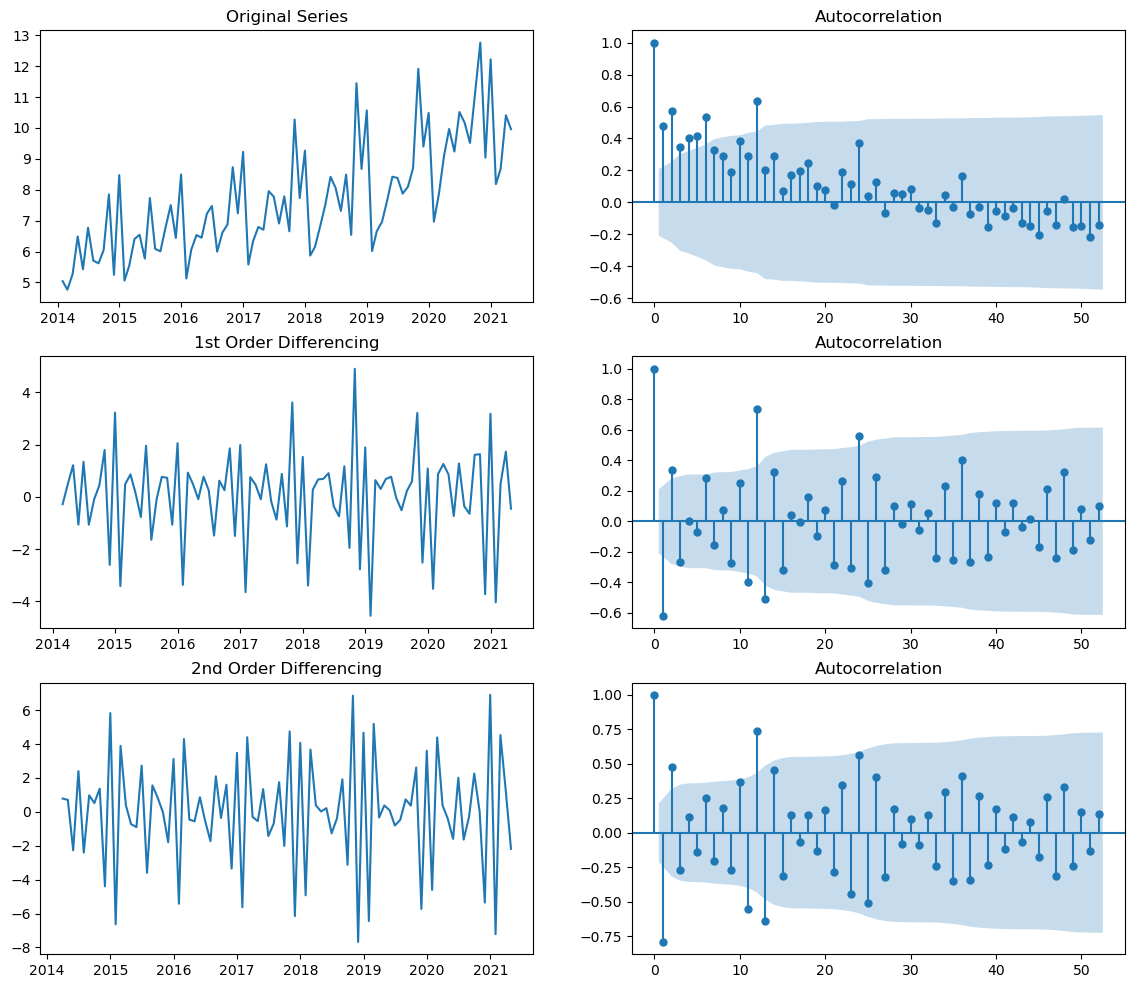

In [231]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(14,12))
axes[0, 0].plot(allstores.sales); axes[0, 0].set_title('Original Series')
plot_acf(allstores.sales, ax=axes[0, 1], lags=52)

# 1st Differencing
axes[1, 0].plot(allstores.sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(allstores.sales.diff().dropna(), ax=axes[1, 1], lags=52)

# 2nd Differencing
axes[2, 0].plot(allstores.sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(allstores.sales.diff().diff().dropna(), ax=axes[2, 1], lags=52)


plt.show()

### Order of AR term (p)
- Check PACF after first-differencing
- Be conservative and set to AR(1)

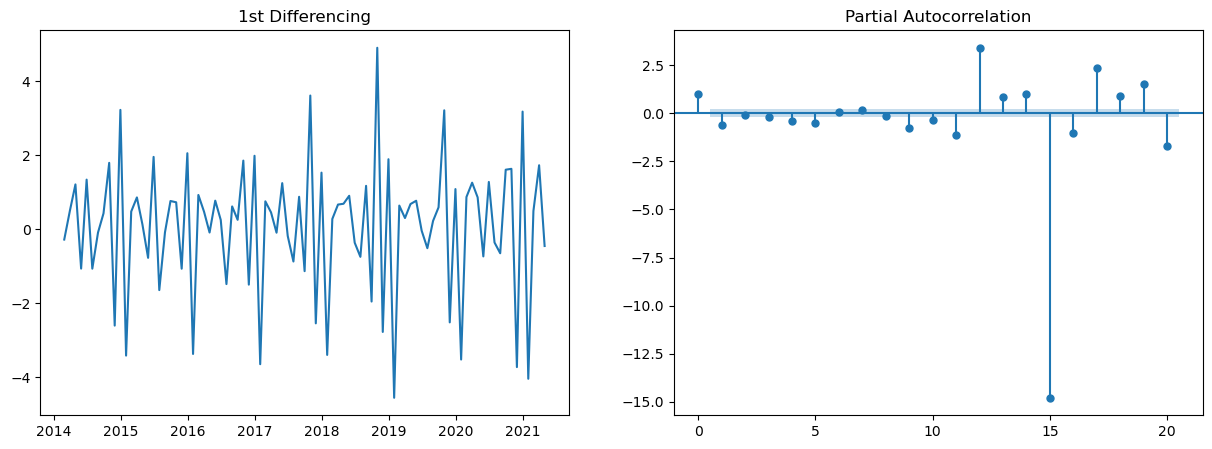

In [232]:
# PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(allstores.sales.diff()); axes[0].set_title('1st Differencing')
plot_pacf(allstores.sales.diff().dropna(), ax=axes[1])

plt.show()

### Oder of MA term (q)
- Lag 1 and 2 above significant level
- Set q = 2

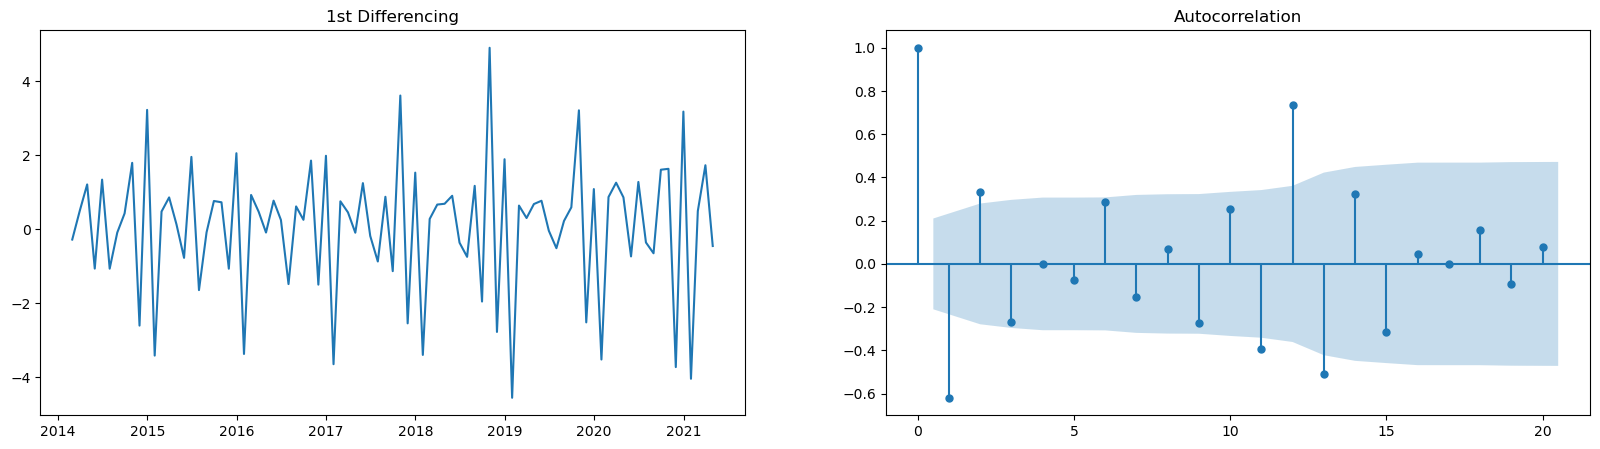

In [233]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
axes[0].plot(allstores.sales.diff()[0:100]); axes[0].set_title('1st Differencing')
plot_acf(allstores.sales.diff().dropna(), ax=axes[1])
plt.show()

### Create features

In [302]:
#allstores = allstores[allstores.index.year>=2014]
def get_features(df):
    
    df_copy = df.copy()
    df_copy['date'] = df_copy.index
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['weekofyear'] = df_copy['date'].dt.weekofyear
    
    features = df_copy[['month','year','weekofyear']]
    
    return features
features = get_features(allstores)
features = pd.get_dummies(features, columns=features.columns, drop_first=True)

In [303]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(allstores.sales, 
              exog=features, 
              order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                   87
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -56.749
Method:                       css-mle   S.D. of innovations              0.453
Date:                Sun, 12 Sep 2021   AIC                            201.499
Time:                        20:36:04   BIC                            309.999
Sample:                    02-28-2014   HQIC                           245.188
                         - 04-30-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7322        nan        nan        nan         nan         nan
month_2           0.6099   1721.888      0.000      1.000   -3374.229    3375.449
month_3           0.8589   1038.875     

### Plot residual errors to check whether there are still patterns
- Looks fine
- Error appears normally distributed
- But there is still seasonality

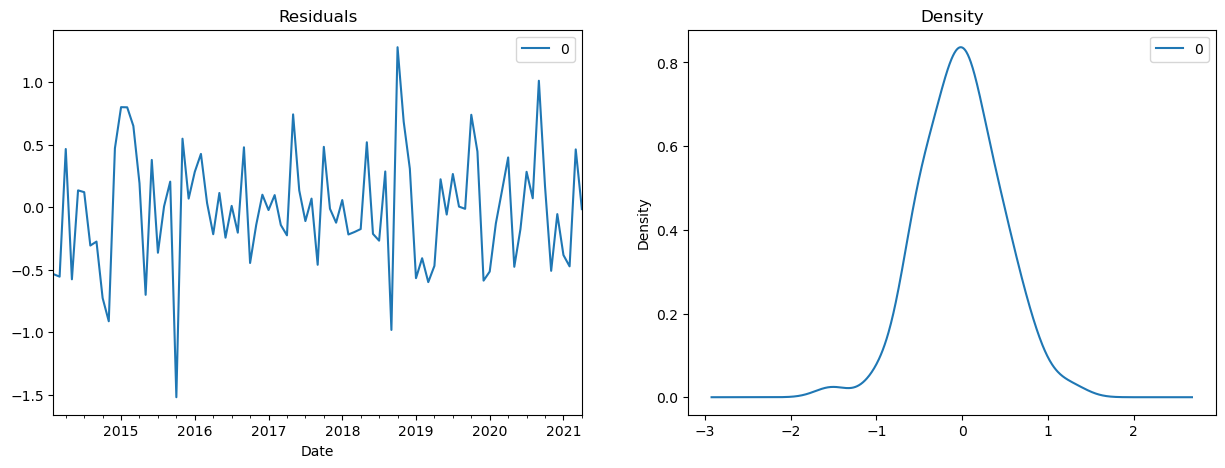

In [306]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Text(0, 0.5, 'Sale Volume (Millions)')

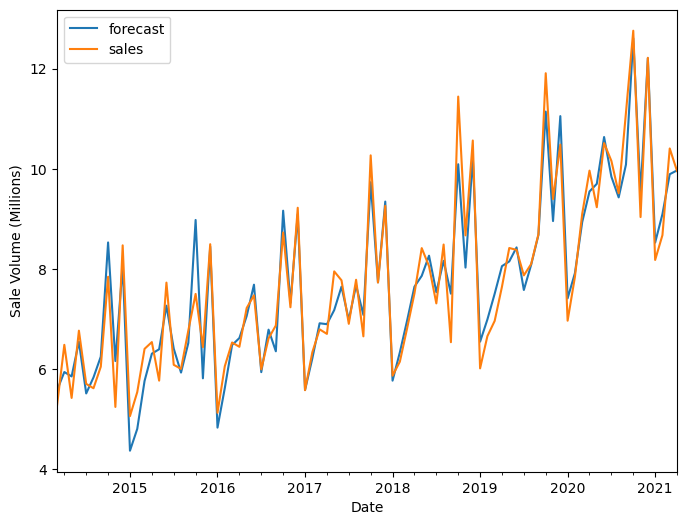

In [307]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=True)
plt.ylabel('Sale Volume (Millions)')

# Try to fit a SARIMAX
- Fit stepwise auto-ARIMA

In [308]:
import pmdarima as pm

smodel = pm.auto_arima(allstores.sales, X=features,
                         start_p=0, start_q=0,
                         test='adf',
                         max_p=5, max_q=5, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=188.571, Time=2.15 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=186.798, Time=0.96 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=184.303, Time=2.45 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=168.000, Time=2.00 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=184.798, Time=0.88 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=169.926, Time=1.10 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=171.286, Time=2.08 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=170.306, Time=3.62 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=170.241, Time=1.84 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=173.948, Time=3.65 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=168.979, Time=2.08 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=167.302, Time=2.31 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=167.053, Time=1.27 sec
 ARIMA(0,0,2)(1,1,0)[12] intercept   : AIC=169.051, Time=3.72 sec
 ARIMA(0,0,2)(1,1,1)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   88
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                 -36.204
Date:                              Sun, 12 Sep 2021   AIC                            164.407
Time:                                      20:37:53   BIC                            271.621
Sample:                                  01-31-2014   HQIC                           207.255
                                       - 04-30-2021                                         
Covariance Type:                                opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.9217      0.197      4.669      0.000       0.535       1.309
month_2       -1.582e-08   4.48e-09     -3.528      0.000   -2.46e-08   -7.03e-09
month_3       -3.463e-08   2.45e-09    -14.139      0.000   -3.94e-08   -2.98e-08
month_4        2.242e-08   1.68e-09     13.382      0.000    1.91e-08    2.57e-08
month_5        1.901e-08   1.89e-09     10.082      0.000    1.53e-08    2.27e-08
month_6        -2.43e-08    2.5e-09     -9.713      0.000   -2.92e-08   -1.94e-08
month_7          5.7e-09    1.8e-09      3.160      0.002    2.16e-09    9.23e-09
month_8        5.367e-09   5.14e-09      1.045      0.296    -4.7e-09    1.54e-08
month_9       -3.015e-09   1.52e-09     -1.984      0.047   -5.99e-09   -3.62e-11
month_10       5.709e-08   1.24e-08      4.620      0.000    3.29e-08    8.13e-08
month_11      -6.981e-08   1.72e-08     -4.068      0.000   -1.03e-07   -3.62e-08
month_12       2.391e-08   1.98e-08      1.210      0.226   -1.48e-08    6.26e-08
year_2015        -0.0993      0.077     -1.284      0.199      -0.251       0.052
year_2016         0.1520      0.087      1.737      0.082      -0.019       0.323
year_2017        -0.0514      0.083     -0.618      0.536      -0.215       0.112
year_2018        -0.3883      0.080     -4.846      0.000      -0.545      -0.231
year_2019        -0.7617      0.094     -8.127      0.000      -0.945      -0.578
year_2020         0.0530      0.152      0.349      0.727      -0.244       0.350
year_2021         0.8587      0.247      3.481      0.000       0.375       1.342
weekofyear_4     -0.1444      0.182     -0.794      0.427      -0.501       0.212
weekofyear_5      0.1409      0.182      0.775      0.438      -0.215       0.497
weekofyear_8     -0.1630      0.576     -0.283      0.777      -1.291       0.965
weekofyear_9      0.1588      0.576      0.276      0.783      -0.969       1.287
weekofyear_13    -0.2923      0.202     -1.447      0.148      -0.688       0.103
weekofyear_14     0.2923      0.202      1.447      0.148      -0.104       0.688
weekofyear_17    -0.4159      0.146     -2.845      0.004      -0.702      -0.129
weekofyear_18     0.4114      0.146      2.815      0.005       0.125       0.698
weekofyear_22  1.901e-08   1.89e-09     10.082      0.000    1.53e-08    2.27e-08
weekofyear_26    -0.6674      0.178     -3.739      0.000      -1.017      -0.318
weekofyear_27     0.6651      0.178      3.726      0.000       0.315       1.015
weekofyear_30    -0.3190      0.236     -1.350      0.177      -0.782       0.144
weekofyear_31     0.3160      0.236      1.337      0.181      -0.147       0.779
weekofyear_35  6.724e-05      0.216      0.000      1.000      -0.423       0.423
weekofyear_36    -0.0012      0.216     -0.005      0.996      -0.424       0.422
weekofyear_39    -0.6373      0.179     -3.553      0.000      -0.989      -0.286

In [320]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(allstores.sales,order=(1,0,2), exogeneous=features,
              seasonal_order=(0,1,1,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model.fit()

Text(0, 0.5, 'Sales Volume (Millions)')

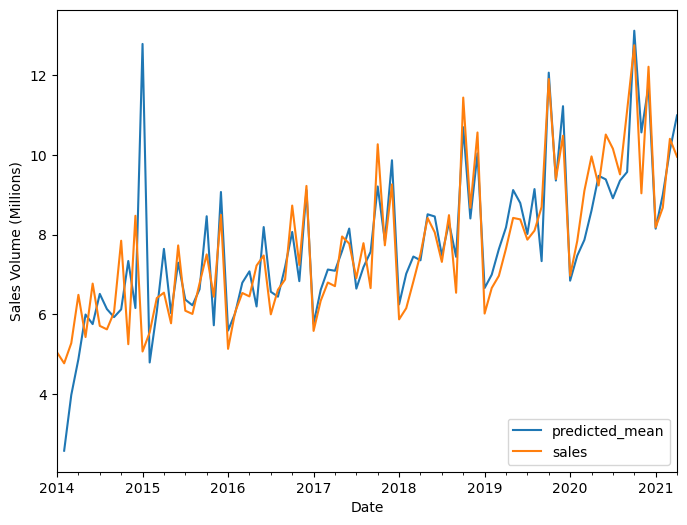

In [321]:
forecast = results.predict(dynamic=False)
forecast[1:].plot(legend=True)
allstores.sales.plot(legend=True)
plt.ylabel('Sales Volume (Millions)')

# Import test data

In [322]:
most_recent_date = sales.Date.max()
most_recent_date
data_recent = pd.read_csv('data/Iowa_Liquor_Sales_recent.csv')
data_recent['Date'] = pd.to_datetime(data_recent['Date'], format='%m/%d/%Y', errors='ignore')
data_recent = data_recent[data_recent.Date.dt.year>=2014]

In [323]:
data_recent = data_recent[(data_recent['Store Name'].str.contains('Hy-Vee'))]
data_recent['Sale (Dollars)'] = data_recent['Sale (Dollars)'].values/10**6

In [324]:
test = data_recent[data_recent.Date>most_recent_date]
test = test.groupby([pd.Grouper(key='Date', freq='M')]).agg(Sale=('Sale (Dollars)','sum'))

In [325]:
plot_data = data_recent[data_recent['Store Name'].str.contains('Hy-Vee')].groupby([pd.Grouper(key='Date', freq='M')]).agg(sales=('Sale (Dollars)','sum'))

In [326]:
test_features = get_features(test)
test_features = pd.get_dummies(test_features, columns=test_features.columns, drop_first=True)
test_features = pd.concat([features, test_features], axis=0)
test_features.fillna(0, inplace=True)
test_features = test_features[-5:]
test_features

month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
Date                                                                        
2021-04-30      0.0      0.0      1.0      0.0        0        0        0   
2021-05-31      0.0      0.0      0.0      0.0        0        0        0   
2021-06-30      0.0      0.0      0.0      0.0        1        0        0   
2021-07-31      0.0      0.0      0.0      0.0        0        1        0   
2021-08-31      0.0      0.0      0.0      0.0        0        0        1   

            month_9  month_10  month_11  ...  weekofyear_31  weekofyear_35  \
Date                                     ...                                 
2021-04-30      0.0       0.0       0.0  ...            0.0              0   
2021-05-31      0.0       0.0       0.0  ...            0.0              0   
2021-06-30      0.0       0.0       0.0  ...            0.0              0   
2021-07-31      0.0       0.0       0.0  ...            0.0              0   
2021-08-31      0.0       0.0       0.0  ...            0.0              1   

            weekofyear_36  weekofyear_39  weekofyear_40  weekofyear_44  \
Date                                                                     
2021-04-30            0.0            0.0            0.0            0.0   
2021-05-31            0.0            0.0            0.0            0.0   
2021-06-30            0.0            0.0            0.0            0.0   
2021-07-31            0.0            0.0            0.0            0.0   
2021-08-31            0.0            0.0            0.0            0.0   

            weekofyear_48  weekofyear_49  weekofyear_52  weekofyear_53  
Date                                                                    
2021-04-30            0.0            0.0            0.0            0.0  
2021-05-31            0.0            0.0            0.0            0.0  
2021-06-30            0.0            0.0            0.0            0.0  
2021-07-31            0.0            0.0            0.0            0.0  
2021-08-31            0.0            0.0            0.0            0.0  

[5 rows x 40 columns]

In [327]:
# Forecast
n_periods = len(test.index)+1
fitted, CI = smodel.predict(n_periods=n_periods, X=test_features, return_conf_int=True)
forecast_index = pd.date_range(allstores.index[-1], periods = n_periods, freq='M')
fitted_series = pd.DataFrame({'predicted_sales':fitted}, index=pd.to_datetime(forecast_index))
fitted_series.index.rename('Date', inplace=True)
CI_L = pd.Series(CI[:, 0], index=forecast_index)
CI_H = pd.Series(CI[:, 1], index=forecast_index)

Text(0.5, 1.0, 'Predicted Sales (Millions)')

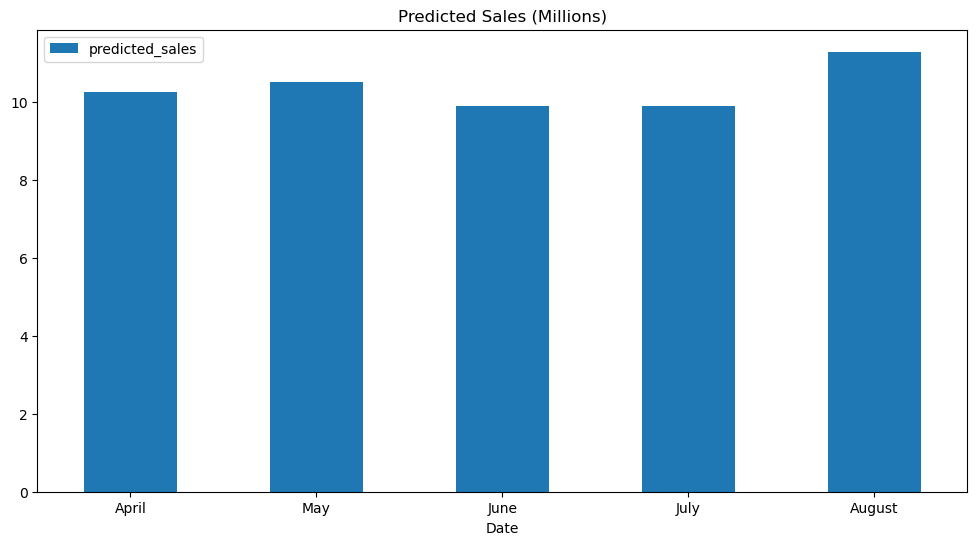

In [328]:
plot_series = fitted_series
plot_series.set_index(plot_series.index.month_name()).plot(kind='bar', figsize=(12,6))
plt.xticks(rotation=360)
plt.title('Predicted Sales (Millions)')

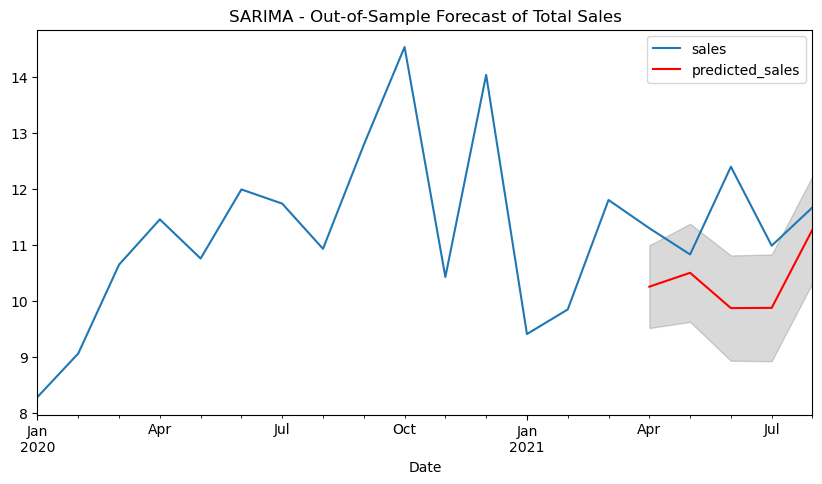

In [329]:
# Plot
f, ax = plt.subplots(figsize=(10,5))
plot_data[plot_data.index.year>=2020].sales.plot(ax=ax, legend=True)
fitted_series.plot(color='red', ax=ax)
plt.fill_between(CI_L.index, 
                 CI_L, 
                 CI_H, 
                 color='k', alpha=.15)

plt.title("SARIMA - Out-of-Sample Forecast of Total Sales")
plt.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'April'),
  Text(1, 0, 'May'),
  Text(2, 0, 'June'),
  Text(3, 0, 'July'),
  Text(4, 0, 'August')])

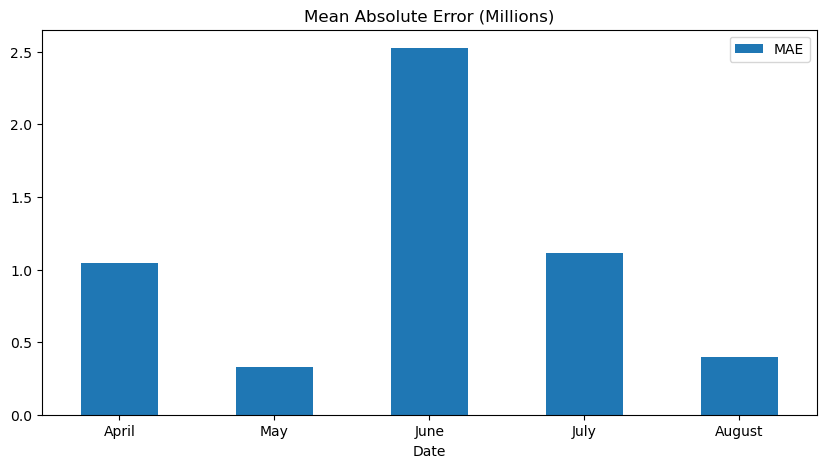

In [330]:
diff = pd.concat([plot_data, fitted_series], axis=1).dropna()
diff.index = diff.index.month_name()
diff['MAE'] = abs(diff['sales'] - diff['predicted_sales'])
diff.plot(kind = 'bar', y='MAE', title='Mean Absolute Error (Millions)', figsize=(10,5))
plt.xticks(rotation=360)